# Introduction

This notebook contains the code and experiments needed to build the Figure 2 of our paper "__Weighted Metamorphosis for registration of images with different topologies__". In addition you will find at the end of each part a gif of the image evolution along with the deformation grid.
In the Figure 2, there is two set of experiments on two different MRI slices. You can see the other one by uncommenting the line 23 of first cell.

ic| sys.path: ['/home/turtlefox/Documents/Doctorat/Demeter/examples/../demeter/',
               '/home/turtlefox/Documents/Doctorat/Demeter/examples',
               '/home/turtlefox/Documents/Doctorat/Demeter',
               '/home/turtlefox/Documents/Doctorat/Demeter/demeter',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python38.zip',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/lib-dynload',
               '',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages',
               '/home/turtlefox/Documents/Doctorat/Demeter']


device used : cuda:0
BraTS2021_00090_seg.png


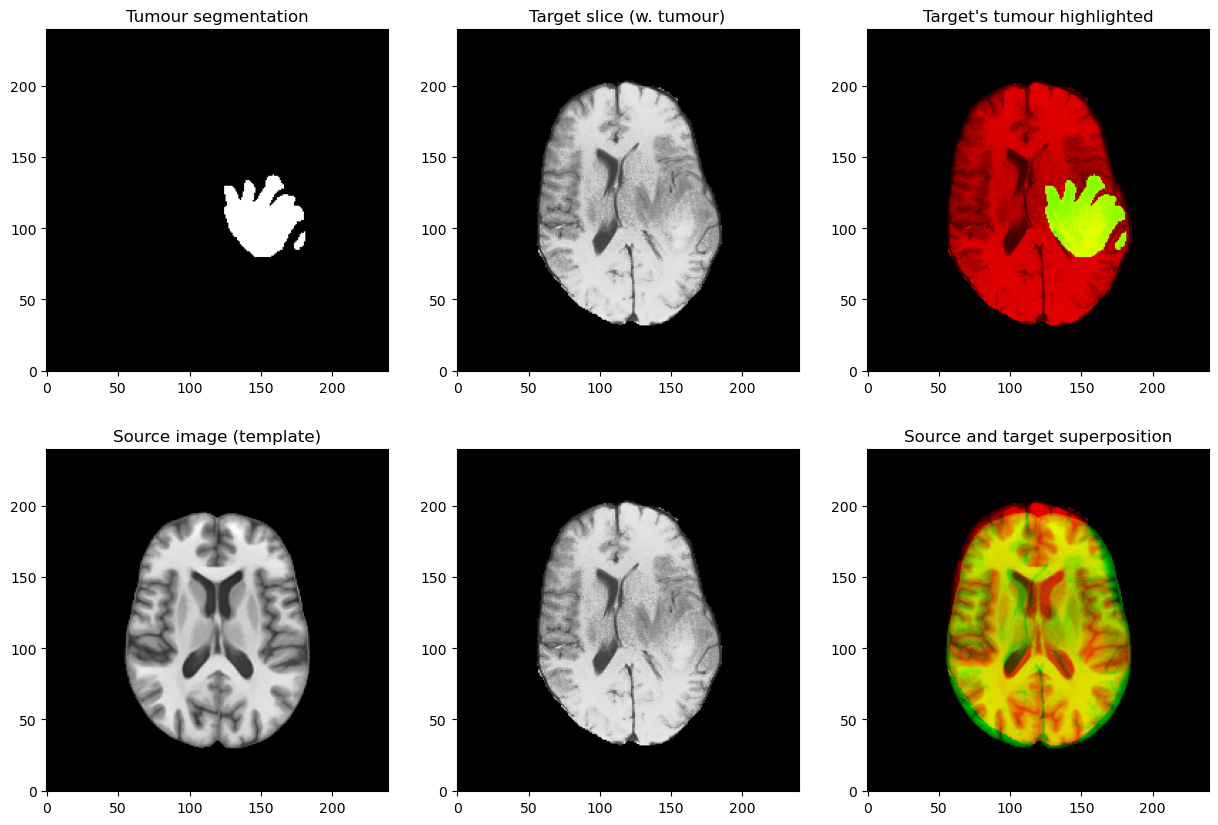

In [1]:
import __init__
import matplotlib.pyplot as plt
import torch
import time
# import my_torchbox as tb
from utils.toolbox import format_time,rgb2gray
from utils.constants import DLT_KW_IMAGE as kws
from utils.constants import ROOT_DIRECTORY

%load_ext autoreload
%autoreload 2
import utils.torchbox as tb
import metamorphosis as mt

cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = 'cuda:0'
torch.autograd.set_detect_anomaly(False)
print('device used :',device)


path = ROOT_DIRECTORY+ '/examples/im2Dbank/'
source_name = "sri24_template.png"
target_name = "BraTS2021_00090_80_.png"
# target_name = "BraTS2021_00147_80_.png"  # To see the other brain presented in the paper, uncomment this line.
seg_name = target_name[:16]+'seg.png'
print(seg_name)
source = torch.tensor(rgb2gray(plt.imread(path+source_name)),dtype=torch.float)[None,None]
target = torch.tensor(rgb2gray(plt.imread(path+target_name)),dtype=torch.float)[None,None]
segmentation = torch.tensor(rgb2gray(plt.imread(path+seg_name)),dtype=torch.float)[None,None]
#print(source.shape,target.shape,segmentation.shape)

fig,ax = plt.subplots(2,3,figsize=(15,10))
ax[0,0].imshow(segmentation[0,0].cpu().numpy(),**kws)
ax[0,0].set_title('Tumour segmentation')
ax[0,1].imshow(target[0,0,:,:].cpu().numpy(),**kws)
ax[0,1].set_title('Target slice (w. tumour)')
ax[0,2].imshow(tb.imCmp(segmentation,target),**kws)
ax[0,2].set_title("Target's tumour highlighted")
ax[1,0].imshow(source[0,0].cpu().numpy(),**kws)
ax[1,0].set_title('Source image (template)')
ax[1,1].imshow(target[0,0,:,:].cpu().numpy(),**kws)
ax[1,2].imshow(tb.imCmp(source,target),**kws)
ax[1,2].set_title('Source and target superposition')
plt.show()

# 0./ How to read the plots
For each Experiments successives plots are showed :
 1. __Cost evolution__
    1. With relative coefficients, (i.e.: we plot $\rho \|z_0\|_{L^2}^2$)
    2. Raw values (i.e.: we plot $\|z_0\|_{L_2}^2$)
 2. __Visualisation of the method end product__. We compare the image at the end of the geodesic ($I_1$) with source and target images
 3. __Geodesic evolution visualisation__. Each row represent a given time point, The first collumn is the image evolution ($I_t$), the second show the residuals ($z_t$) and the third the deformation generated by the field $v_t$.
 4. __Deformation visualisation.__ In this series of plot we show the quality of the end deformation $\Phi = \int_0^1 v_t dt; v_0 = Id$
     1. Deformation grid of $\Phi$
     2. Quiver plot of $\Phi$
     3. (4 images) Comparison of the image deformed by $\Phi$ with the source and target images.


# 1./ Classical methods : LDDMM and Metamorphosis

Before demonstrating the Weighted Metamorphosis results, lets show how LDDMM and the classical Methamorphosis behave on this toy examples.

## 1.a. LDDMM

This method is used for registering images with same topology. The matching is done solely by deformation. The image evolution being
$$ \dot I_t = -  \nabla I_t \cdot v_t$$

We solve the cost:
$$H(z_0) =   \frac 12\| I_{1} - T \|_{L_2}^2 + \lambda  \|v_0\|^2_V $$
with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - K_\sigma \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right>
\end{array}
\right.
$$

Progress: [##########] 100.00% Done...  ,   75.32).
 (ssd :  ,   75.32).
Computation of forward done in  0:03:55s and 0.347cents  s

Computation of lddmm done in  0:03:55s and 0.358cents  s

Computation done in  0:03:55s and 0.358cents  s


(<Figure size 1500x2500 with 25 Axes>,
 array([[<AxesSubplot:title={'center':'t = 0.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.2'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.5'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.7'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 1.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>]],
       dtype=object))

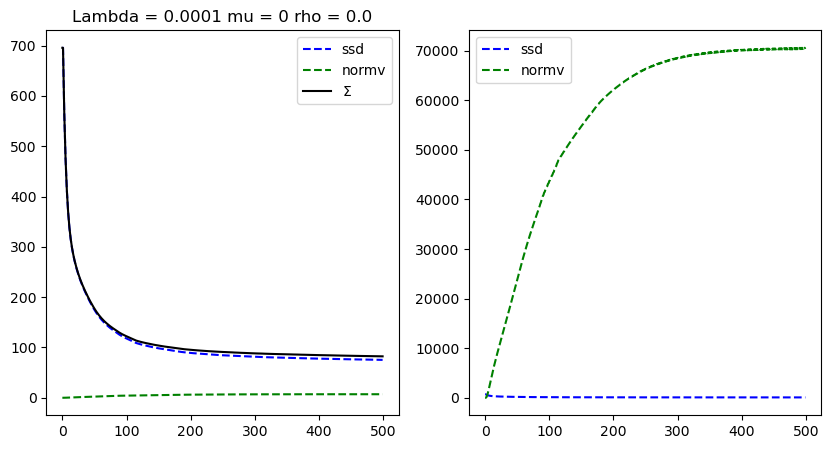

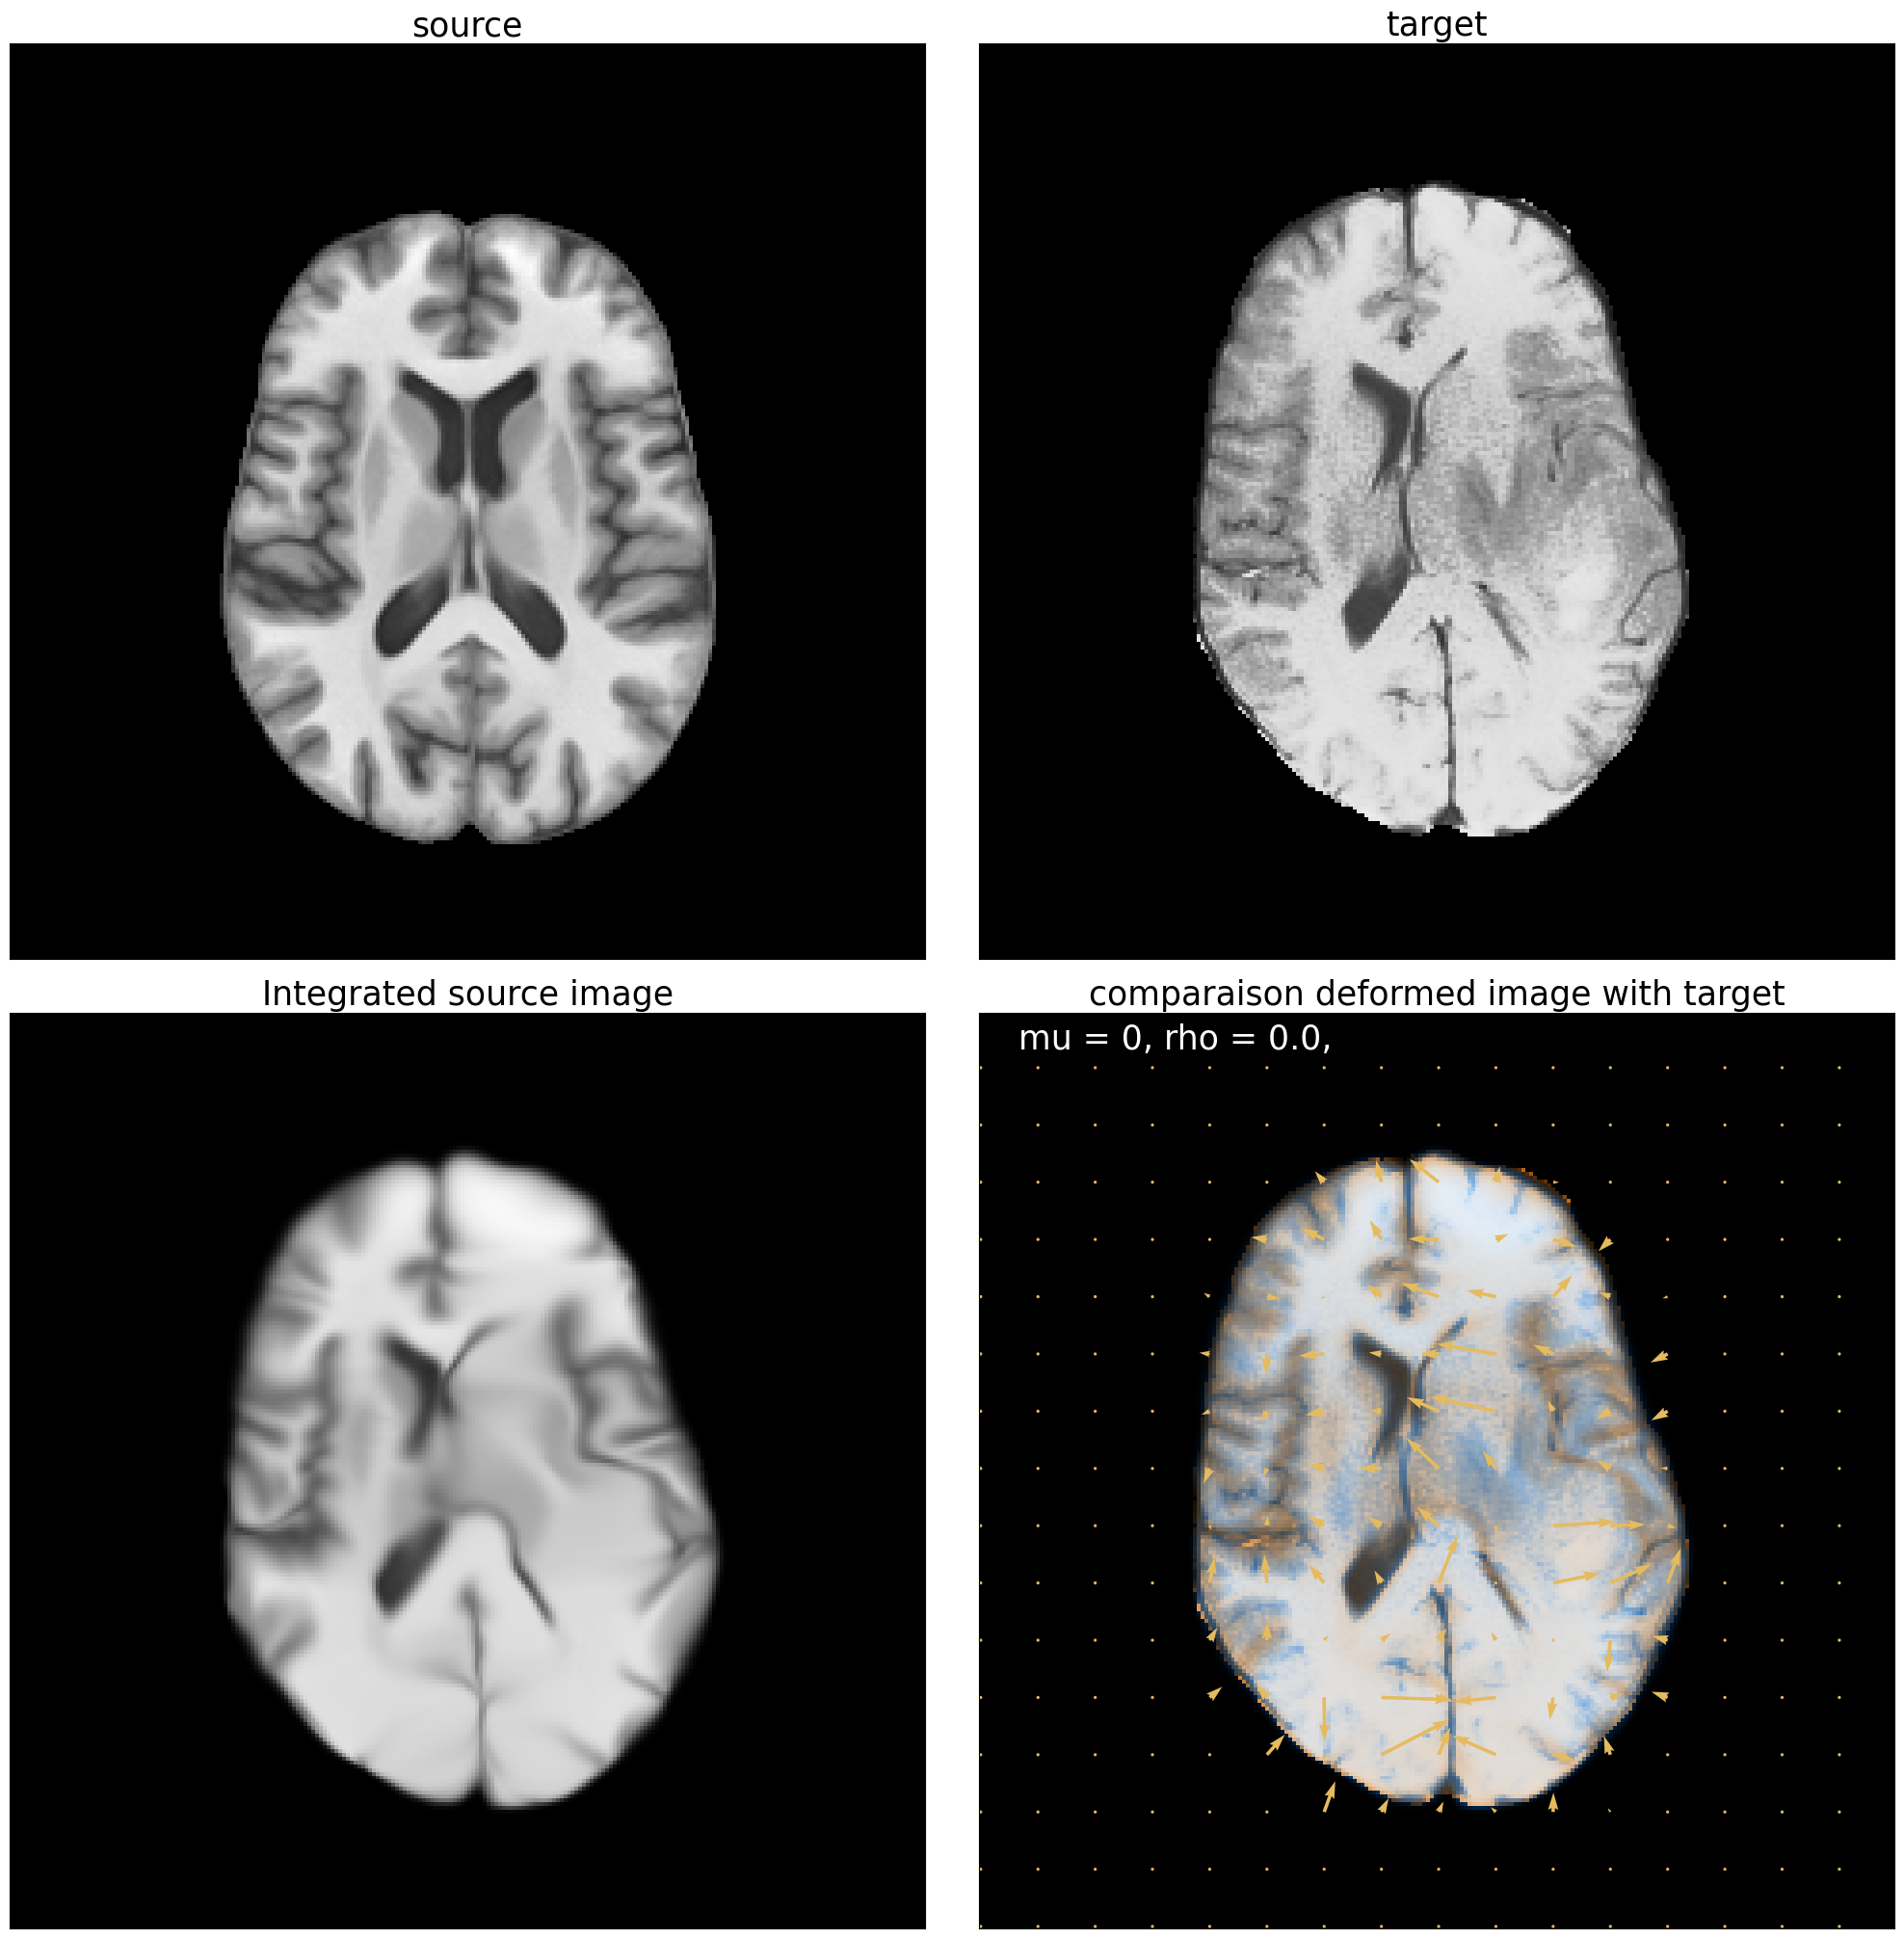

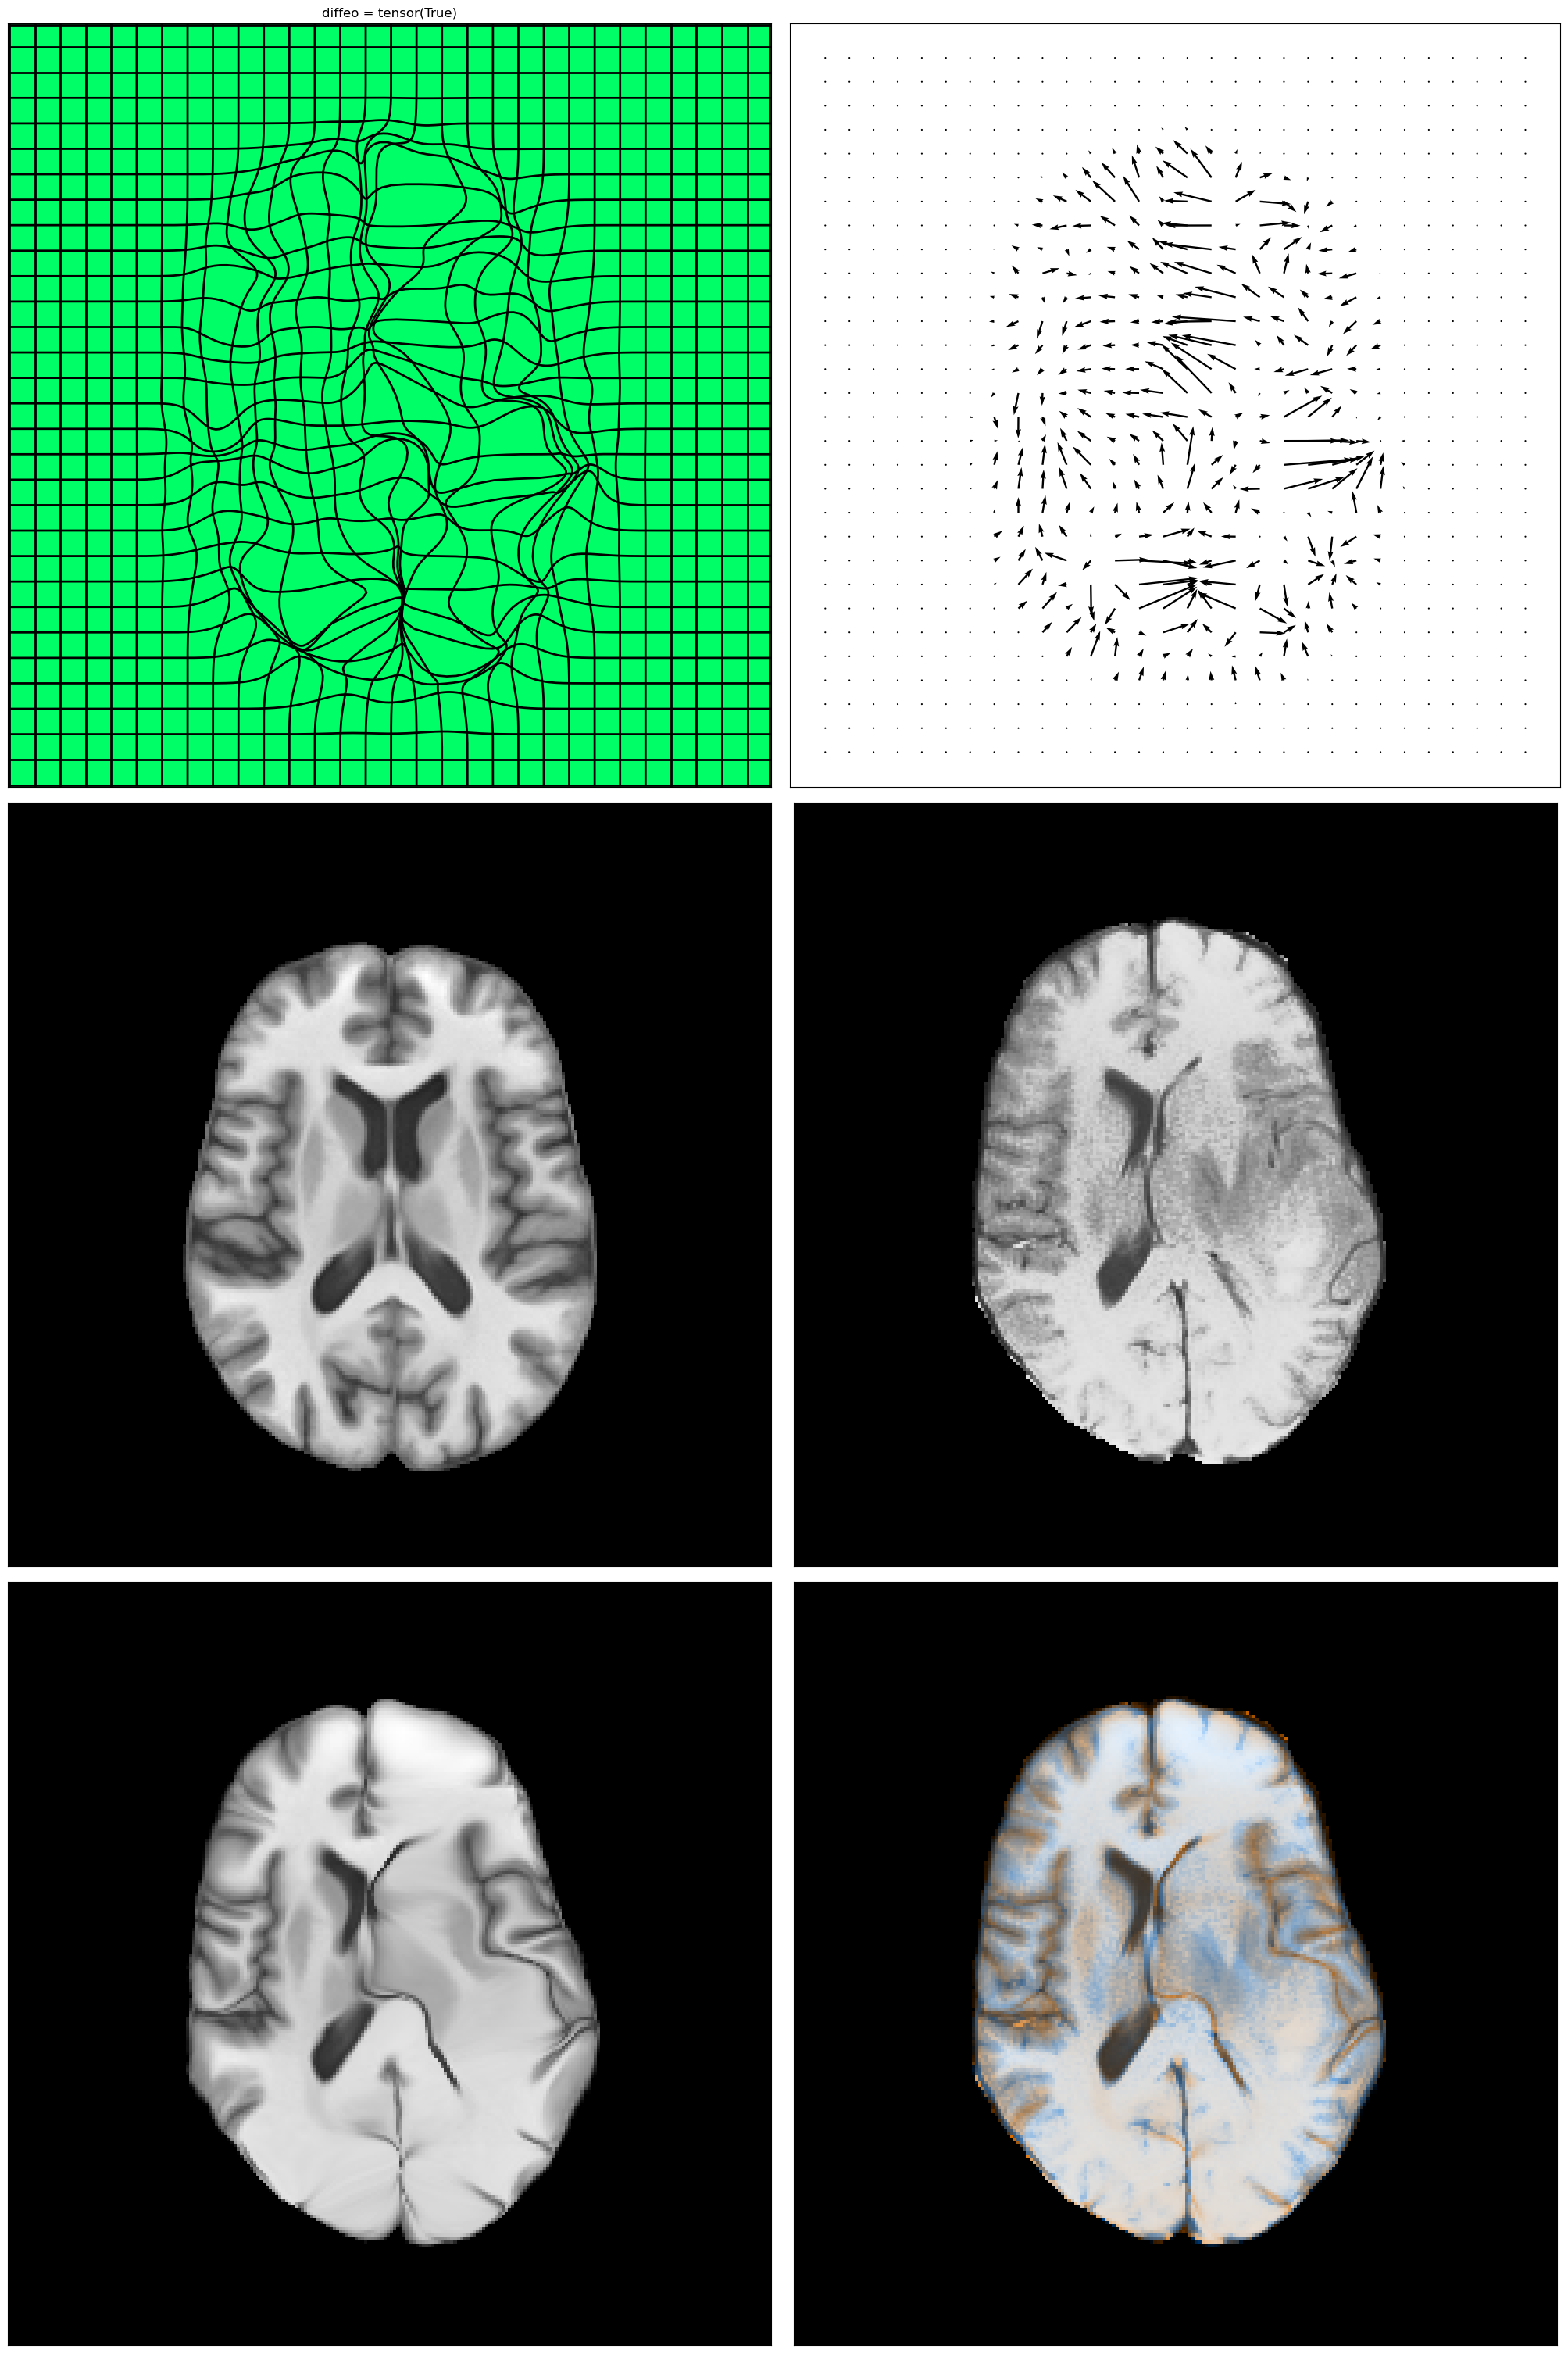

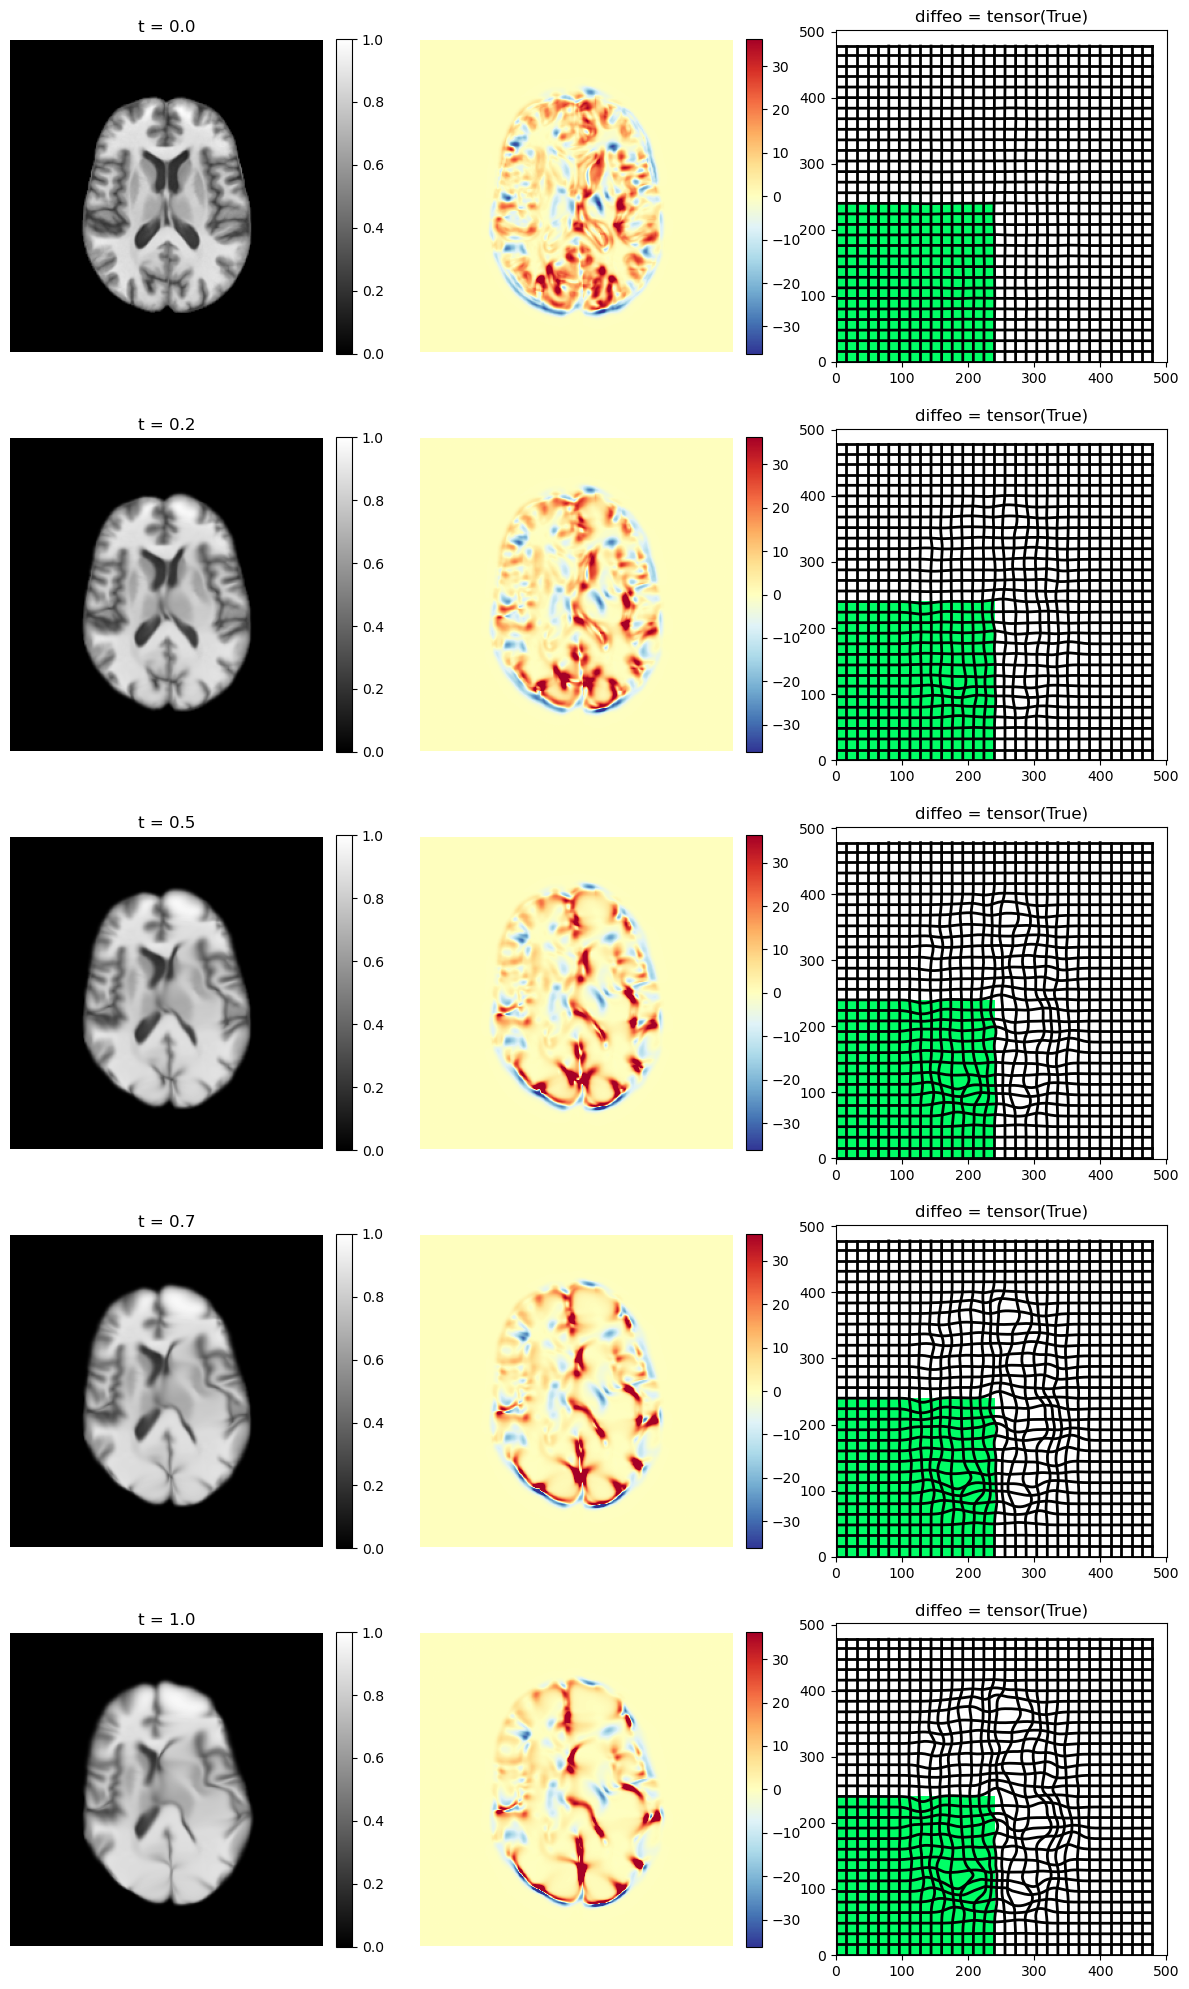

In [2]:
sigma,cost_cst = (6,.0001)
integration_step,n_iter,grad_coef = (20,500,100)
residuals = 0 # equal to the momentum in the LDDMM case
start = time.time()
mr_lddmm = mt.lddmm(source,target,residuals,sigma,cost_cst,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_lddmm.plot()
mr_lddmm.plot_deform()
mr_lddmm.mp.plot()

<img src="gifs/brains_WBIR_BraTS2021_00090_LDDMM.gif" width="750" align="center">

## 1.b Metamorphosis

Now we consider the Metamorphosis method. This method is used for registering images with different topologies. The matching is done by deformation and adding intensity changes, names residuals ($z$).
The image evolution being
$$ \dot I_t = -  \nabla I_t \cdot v_t + \mu z_t; \mu \in \mathbb R$$

We optimise with the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$

Progress: [##########] 100.00% Done...  ,   64.00).
 (ssd :  ,   62.04).
Computation of forward done in  0:01:44s and 0.818cents  s

Computation of metamorphosis done in  0:01:44s and 0.819cents  s

Computation done in  0:01:44s and 0.819cents  s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 1500x2500 with 25 Axes>,
 array([[<AxesSubplot:title={'center':'t = 0.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.2'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.5'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.7'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 1.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>]],
       dtype=object))

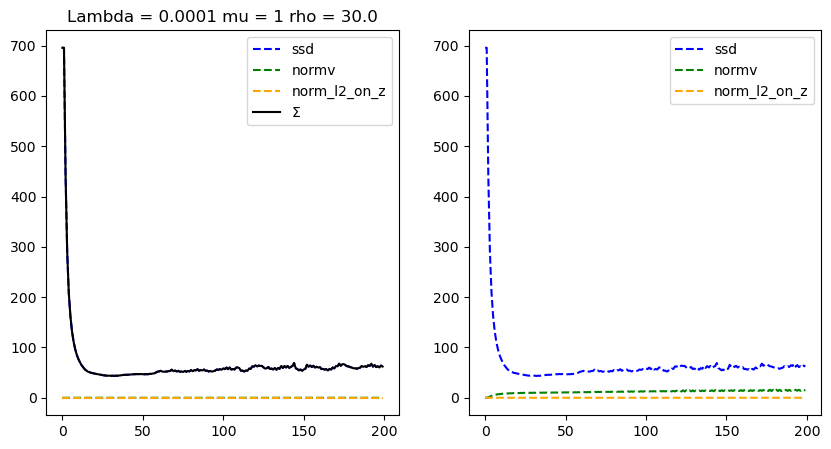

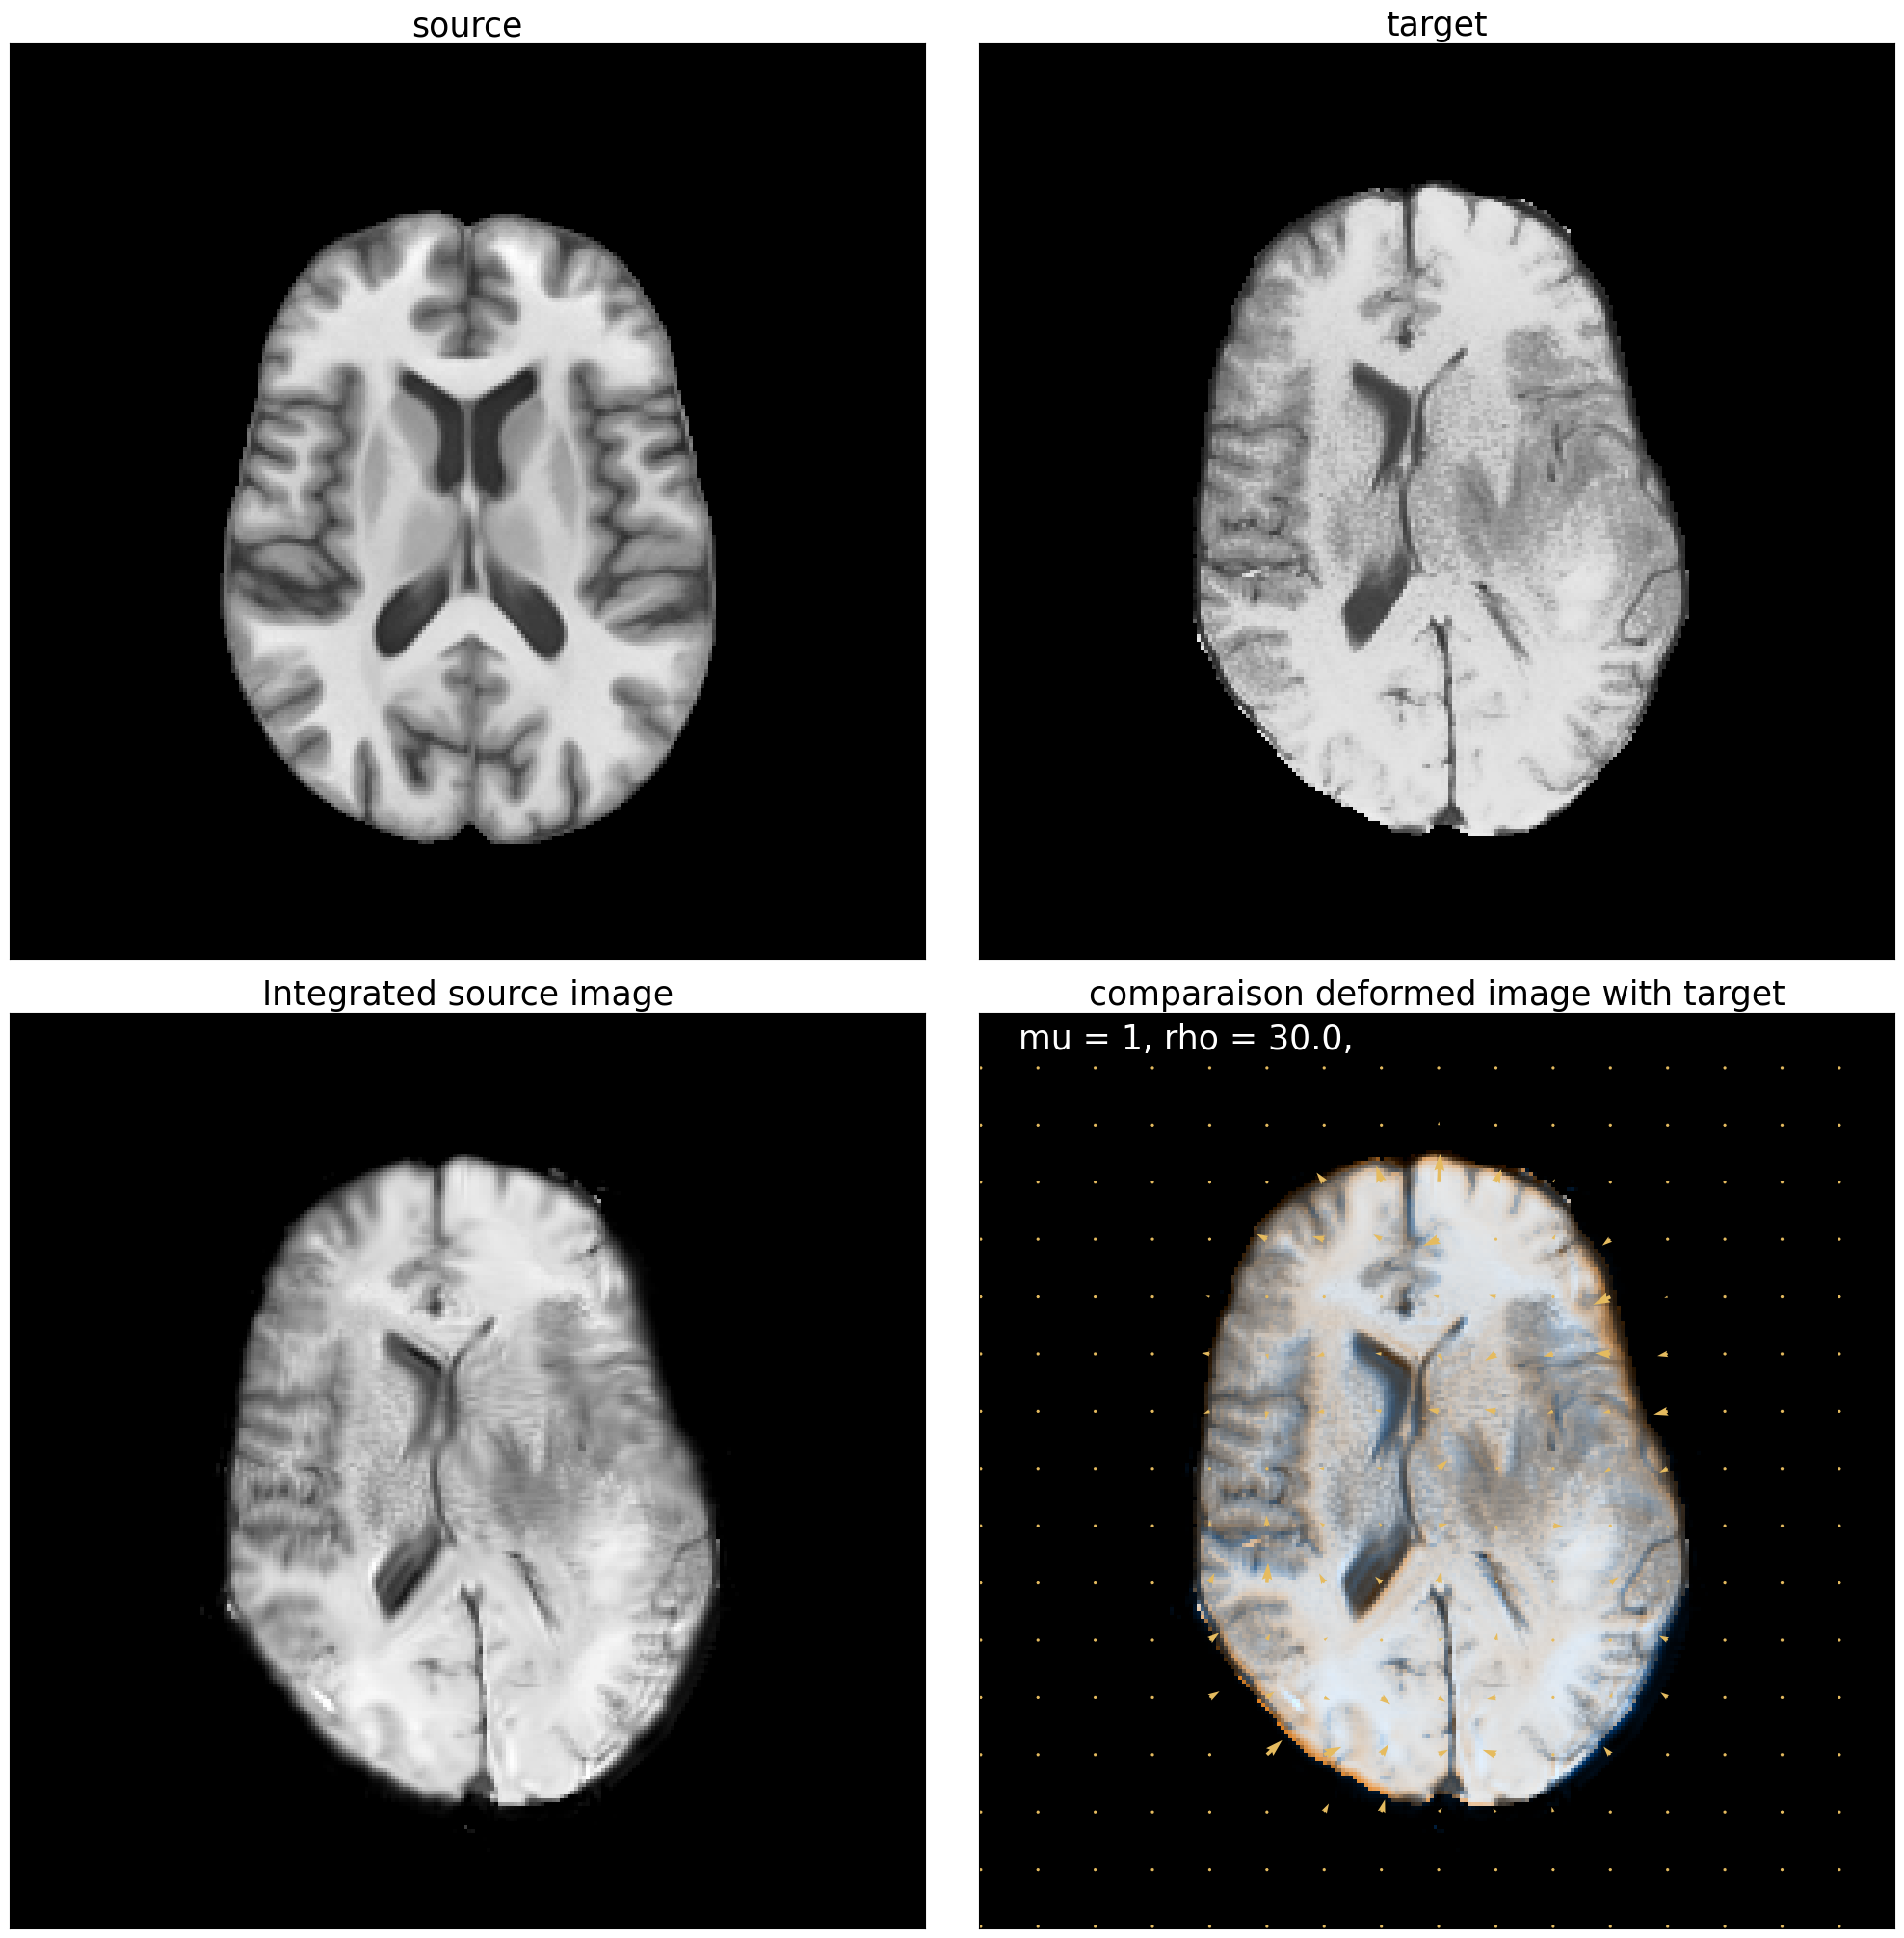

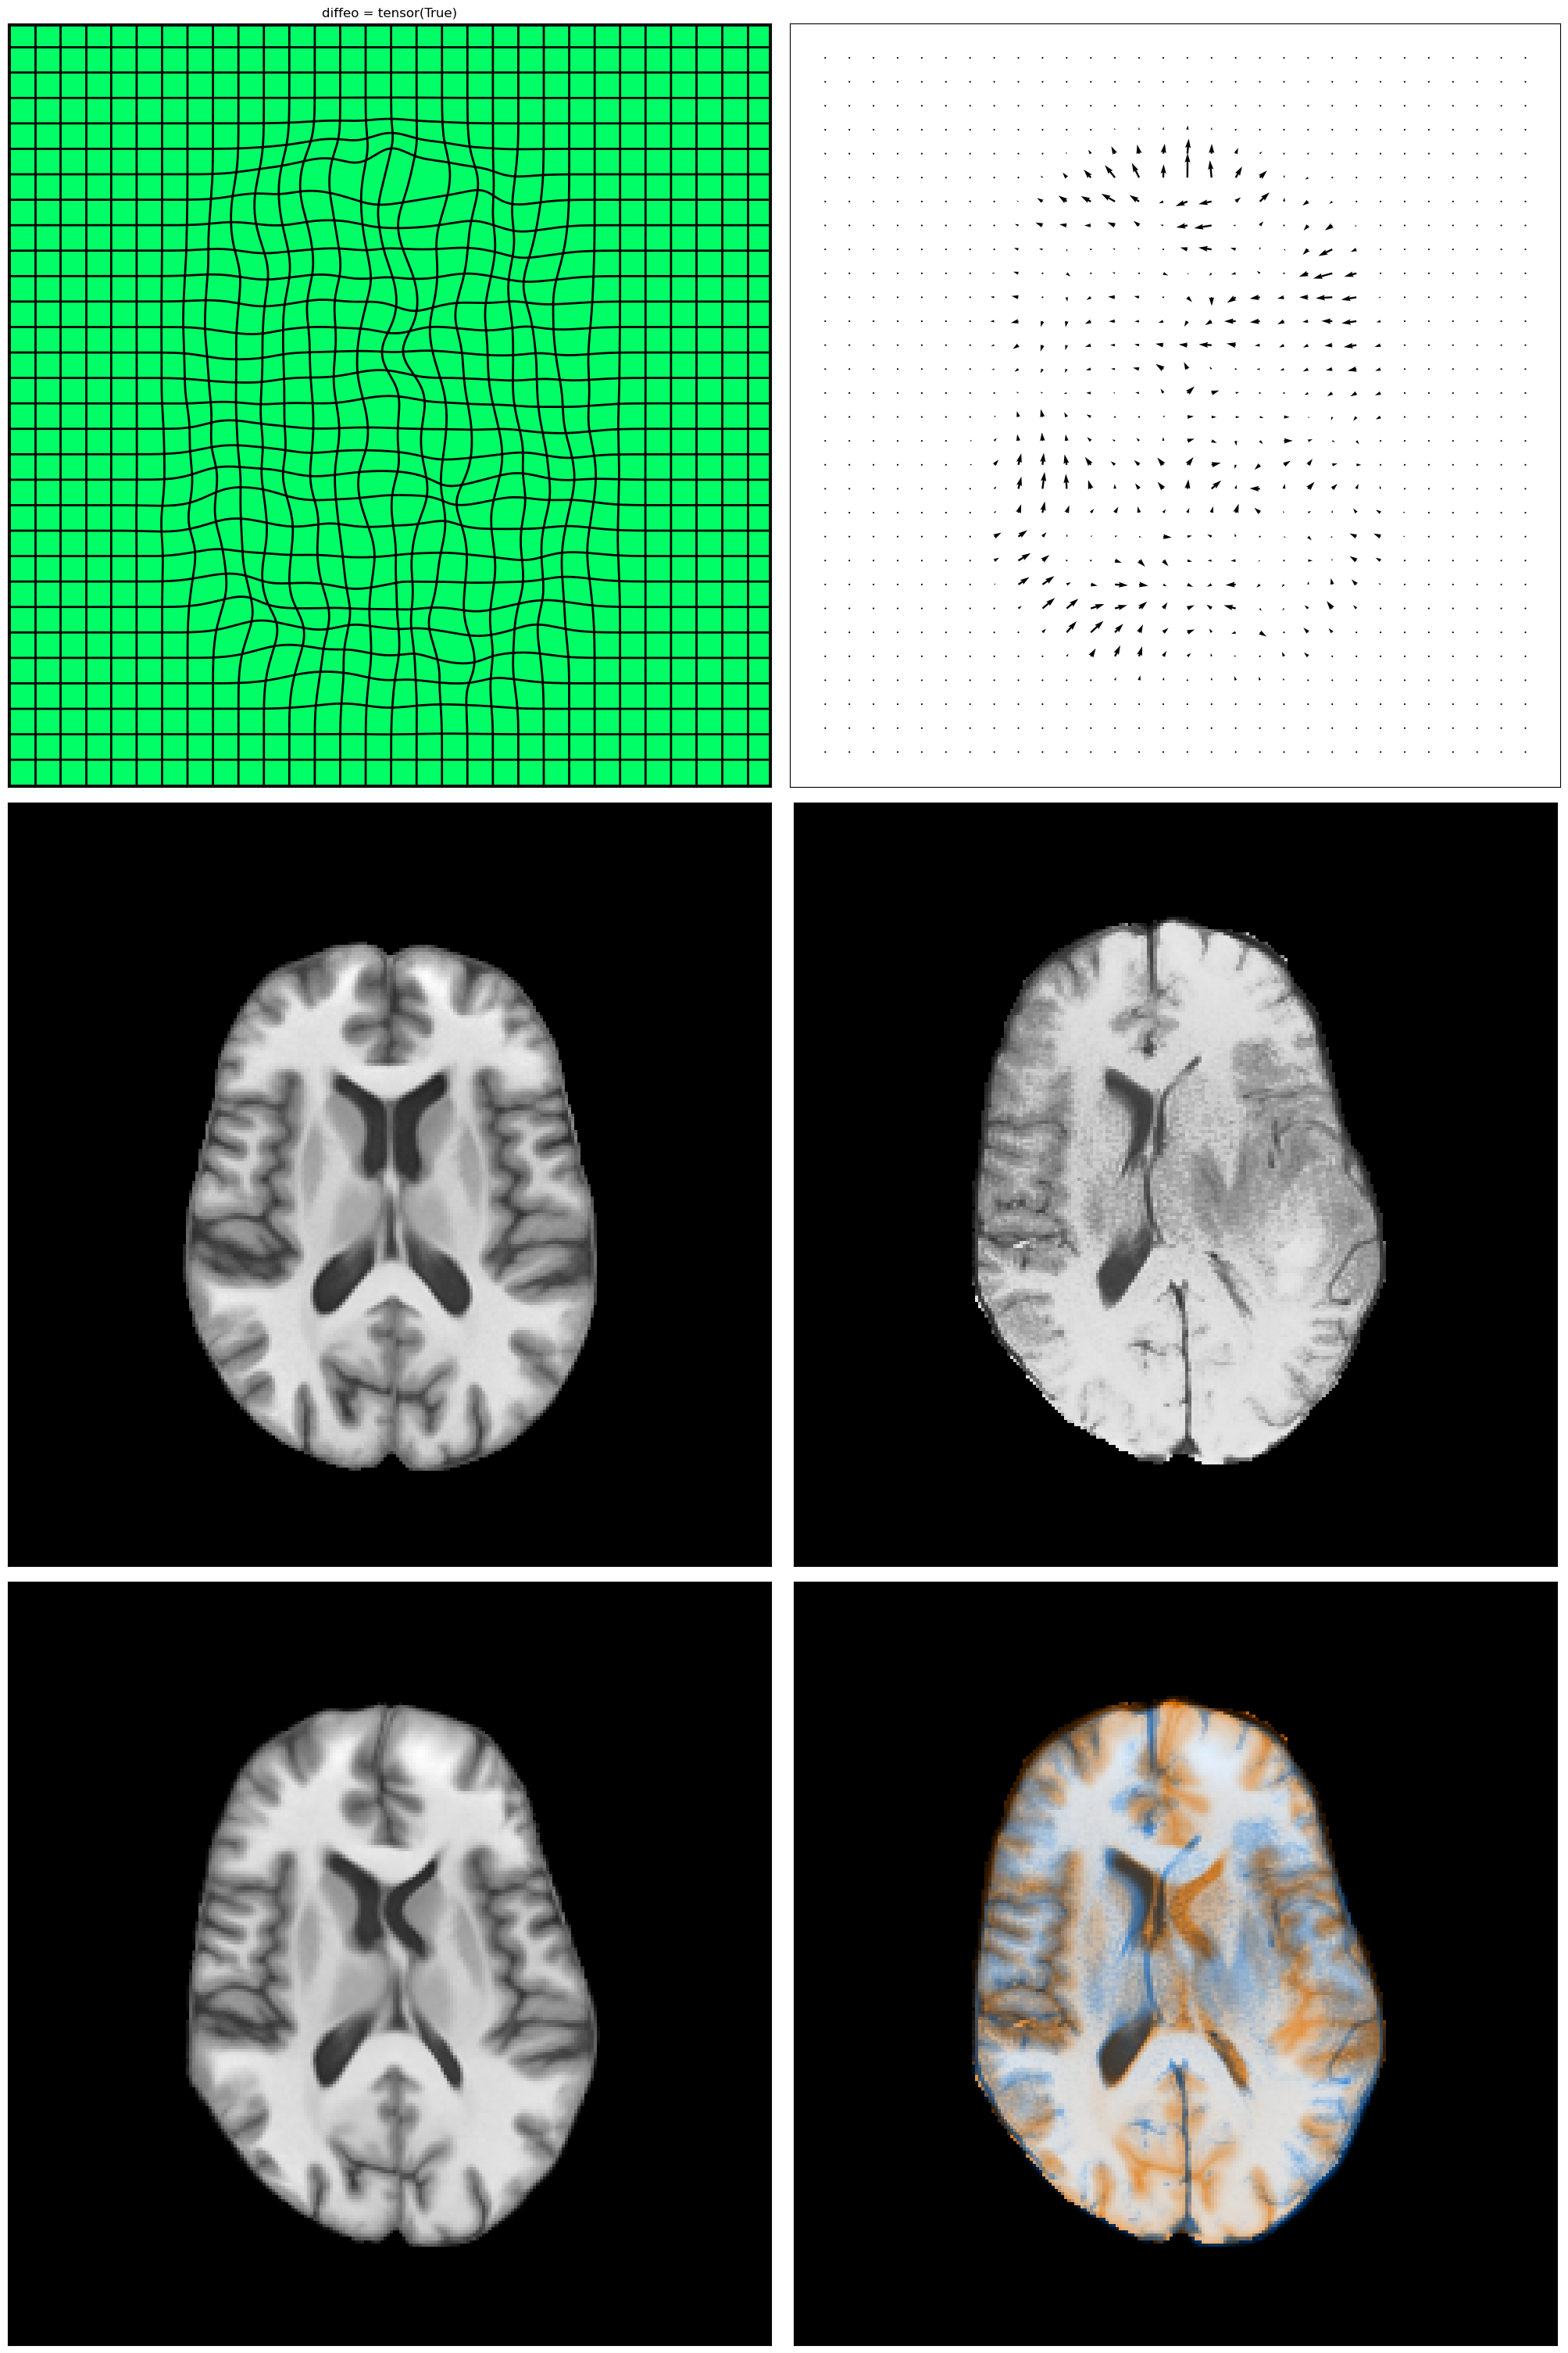

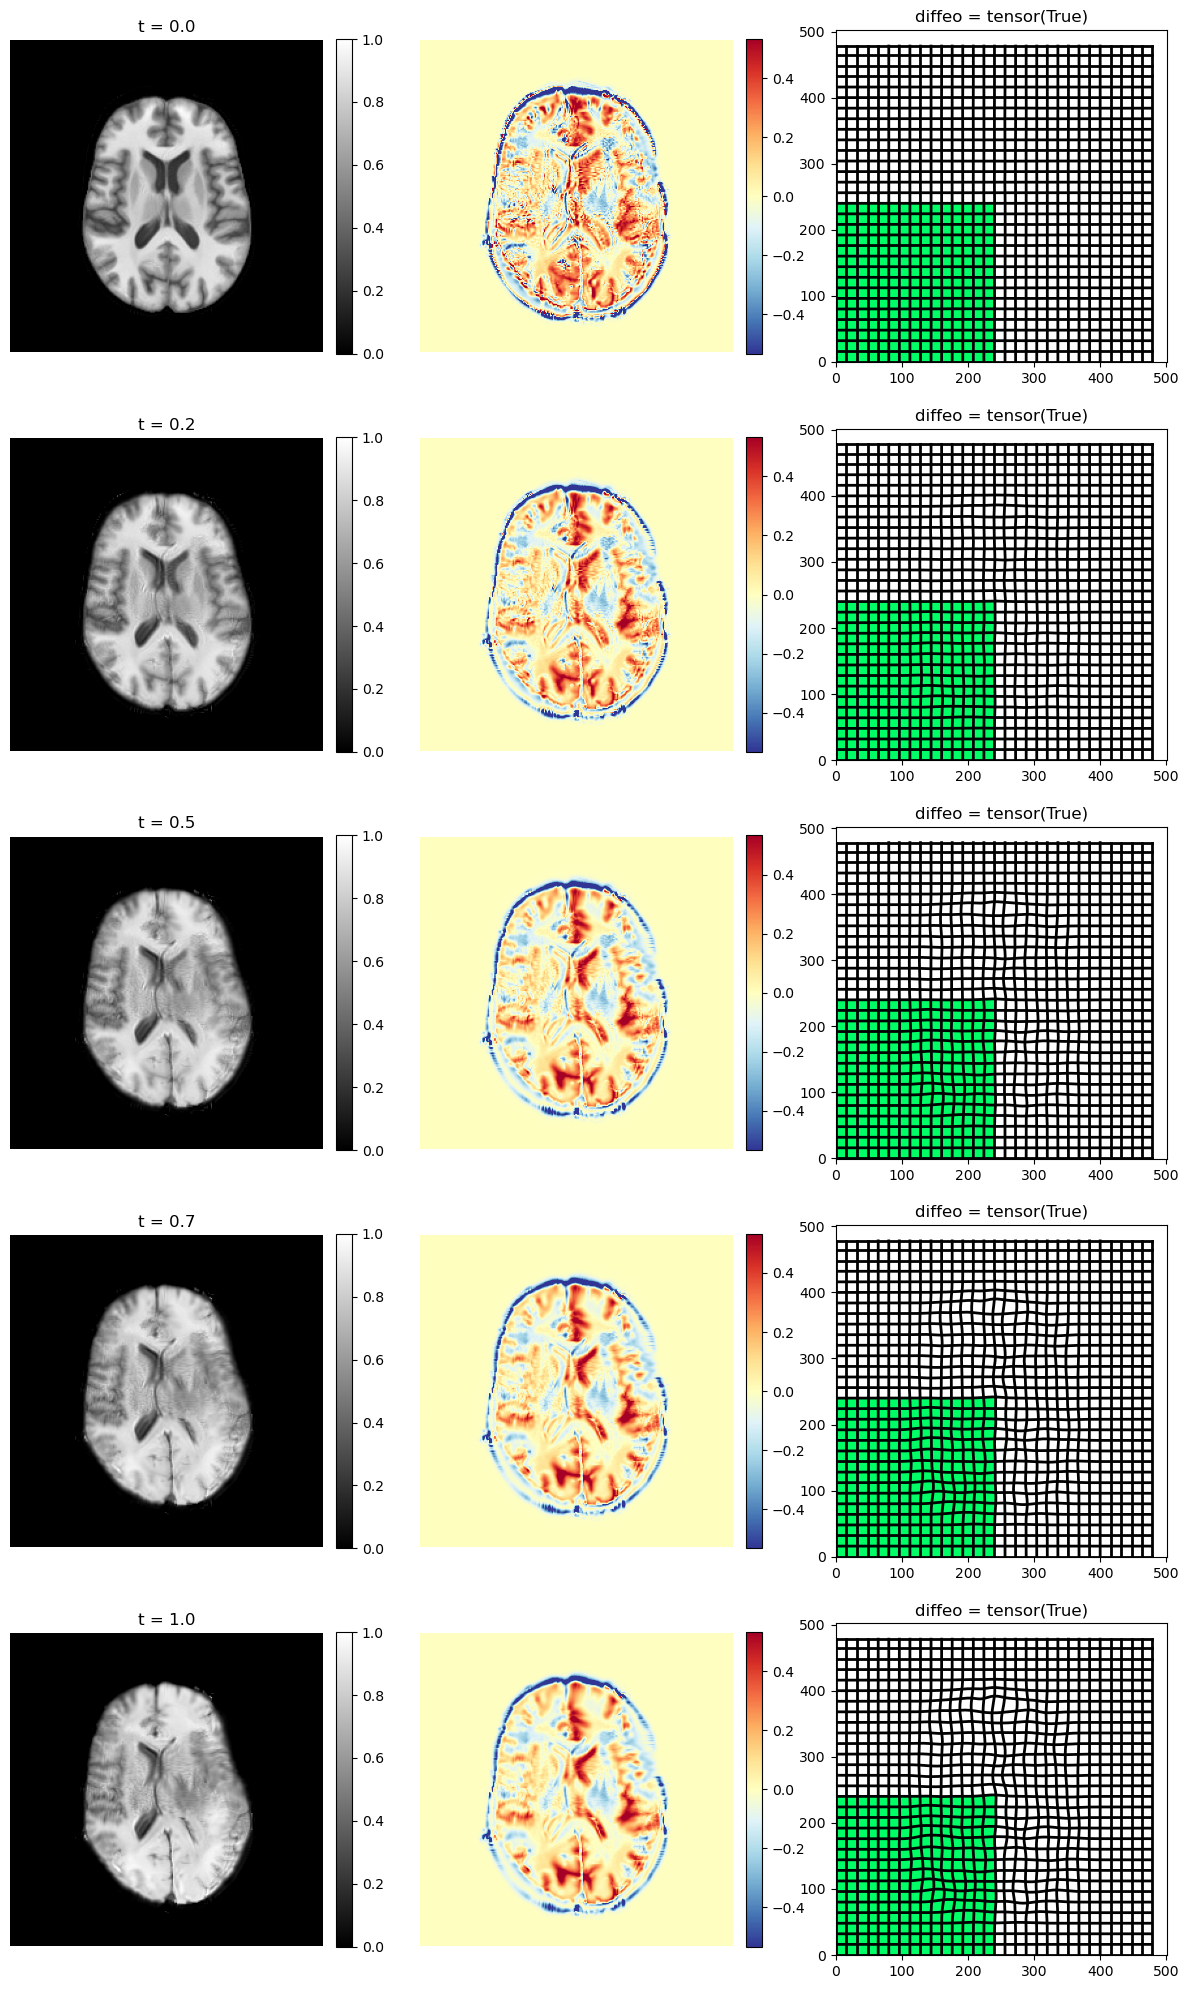

In [7]:
mu,rho,lamb,sigma = (1,30,.0001,6)
integration_step,n_iter,grad_coef = (20,200,10)
residuals = 0
start = time.time()
mr_meta = mt.metamorphosis(source,target,residuals,mu,rho,sigma,lamb,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_meta.plot()
mr_meta.plot_deform()
mr_meta.mp.plot()

<img src="gifs/brains_WBIR_BraTS2021_00090_meta_3.gif" width="750" align="center">




# 2./ Weighted Metamorphoses.


We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|\sqrt{M_0}z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu M_t z_t
\end{array}
\right.
$$

## Mask construction

centre = (tensor(153), tensor(108)), r = 7 and the seg and ball have 145 pixels overlapping
Progress: [##########] 100.00% Done...  ,   64.36).
 (ssd :  ,   64.31).
Computation of forward done in  0:02:14s and 0.116cents  s

Computation of lddmm done in  0:02:14s and 0.117cents  s


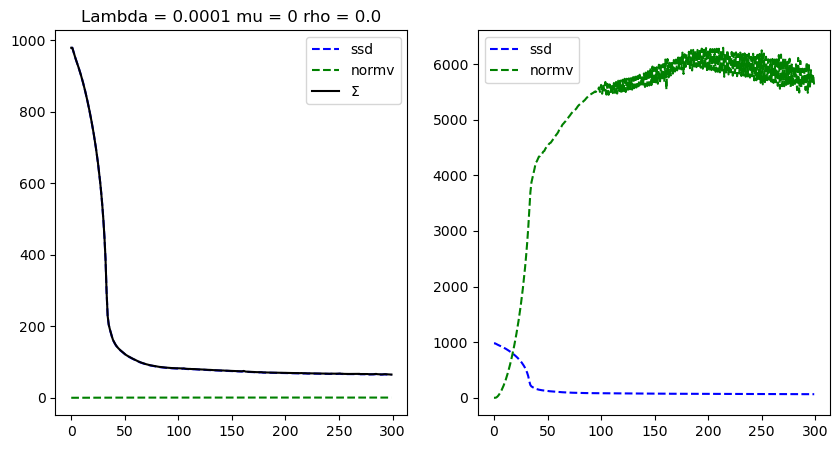

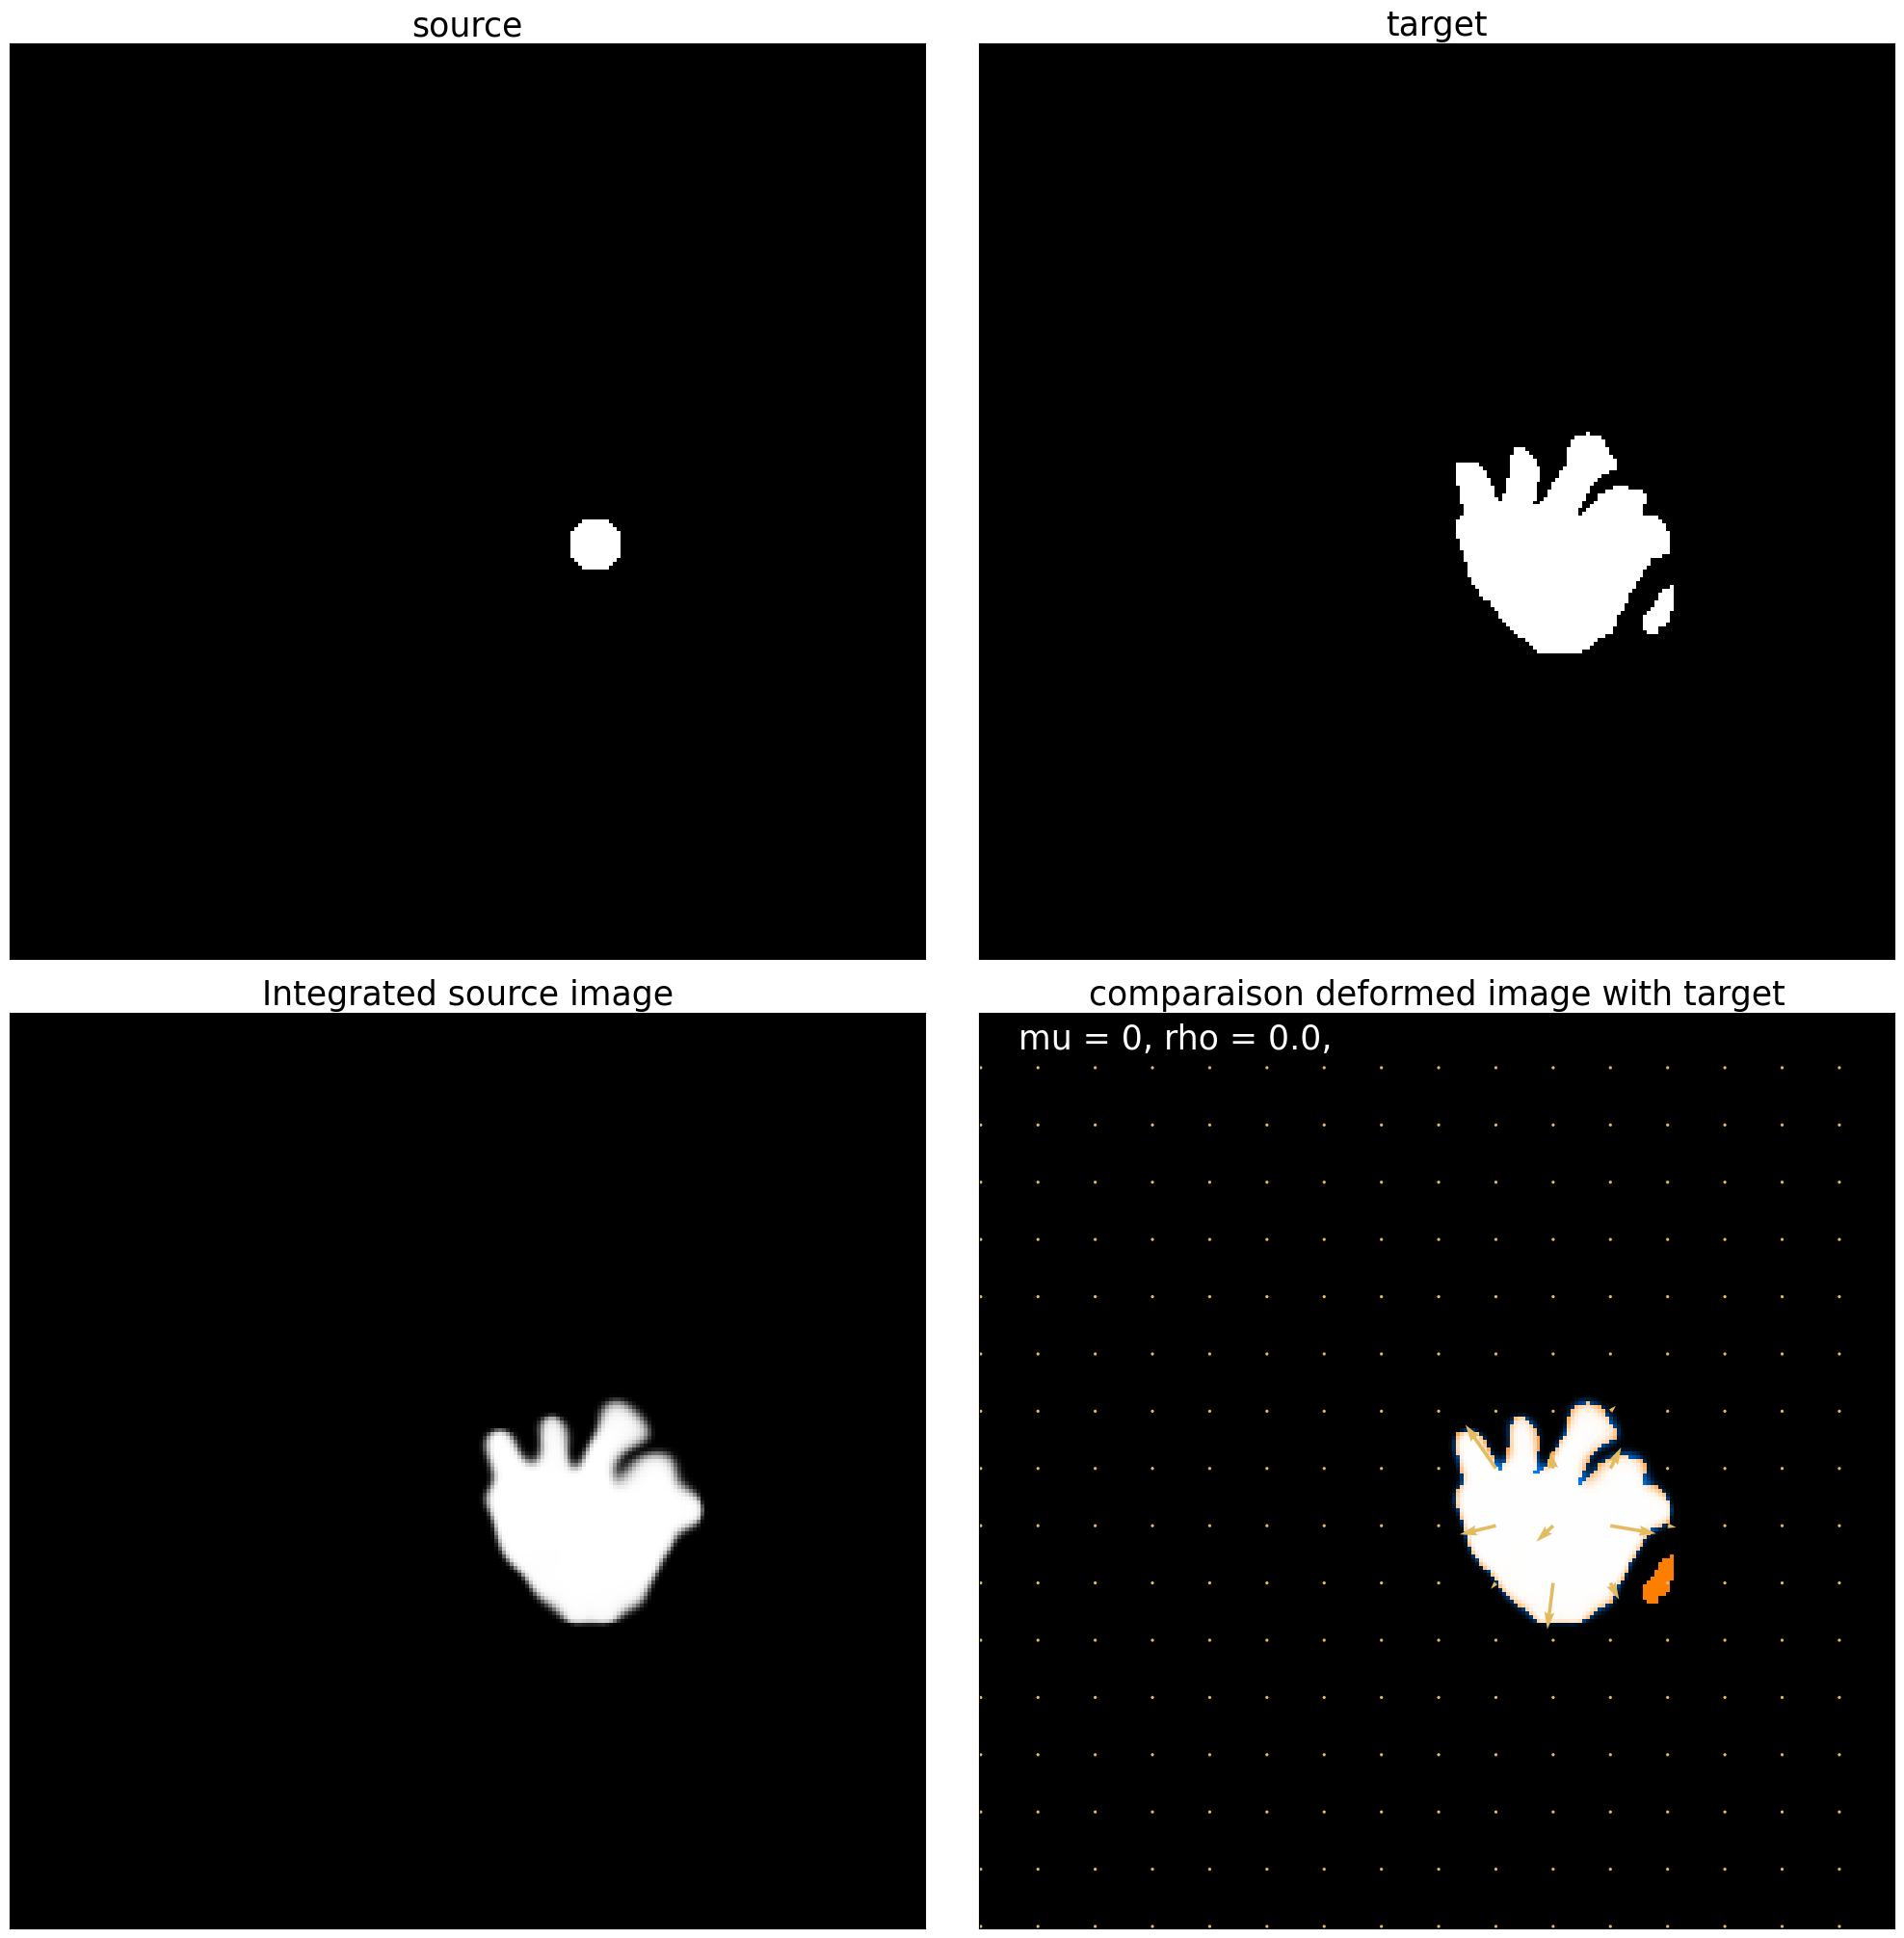

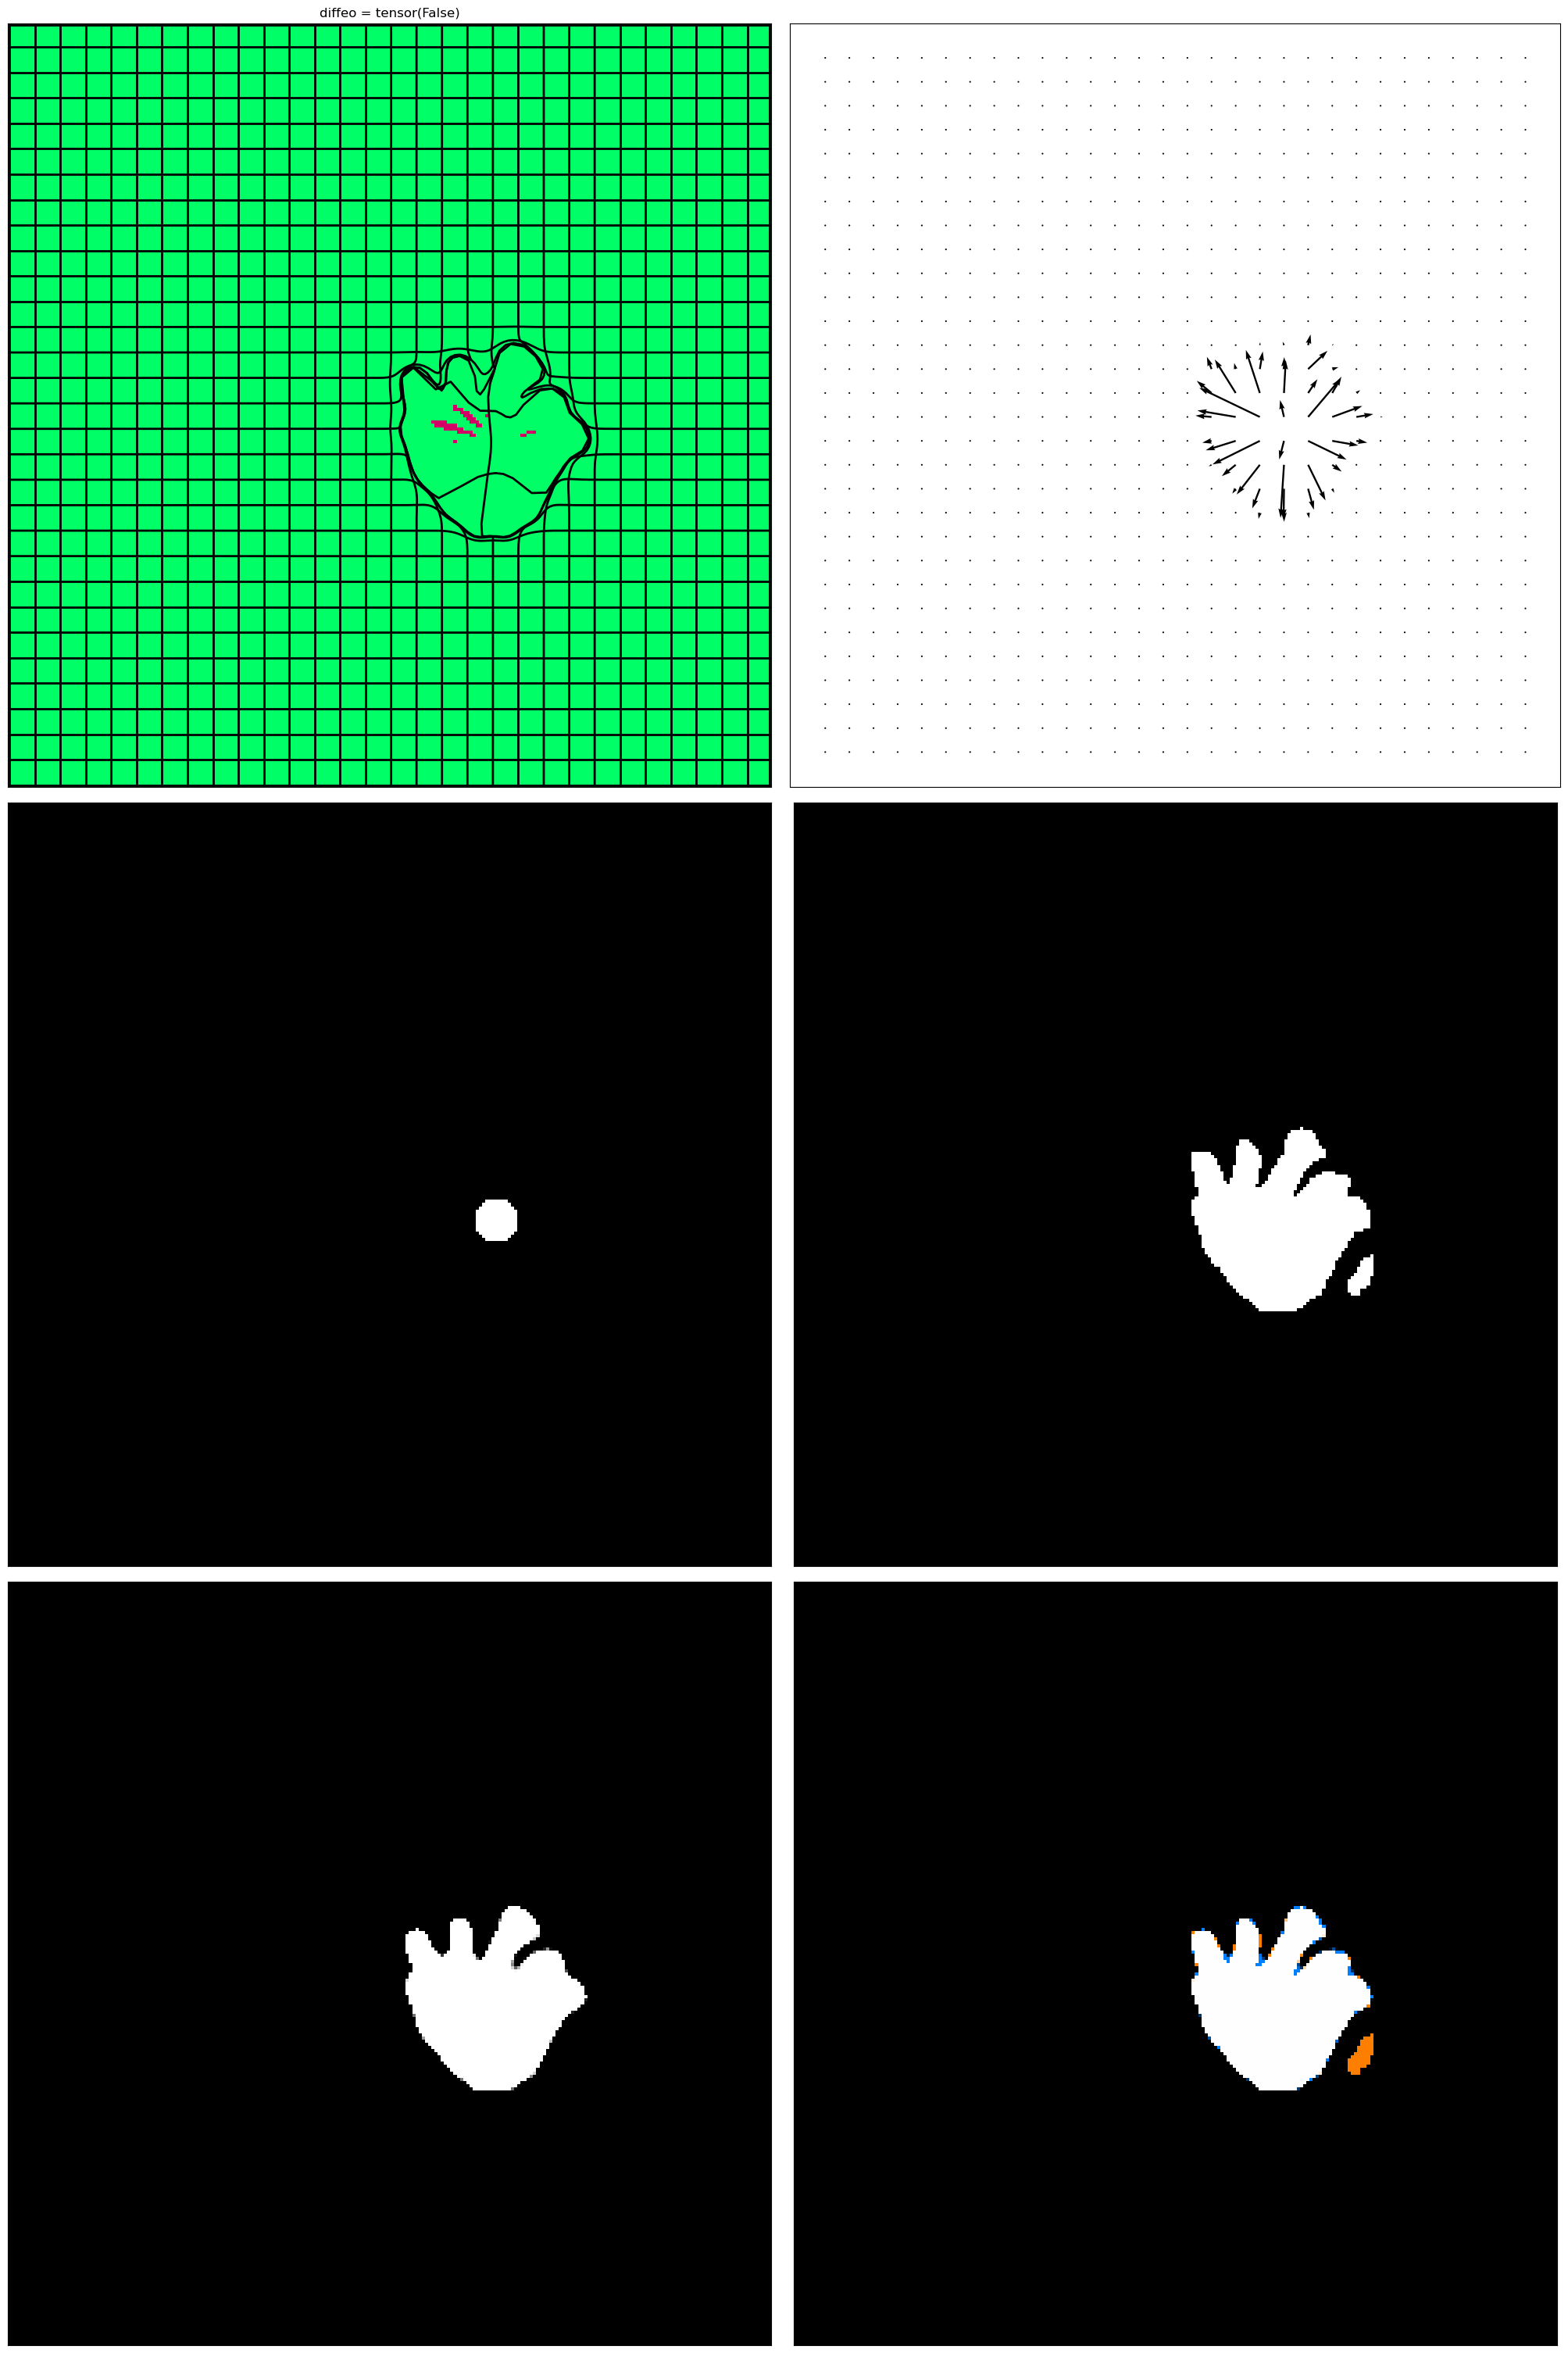

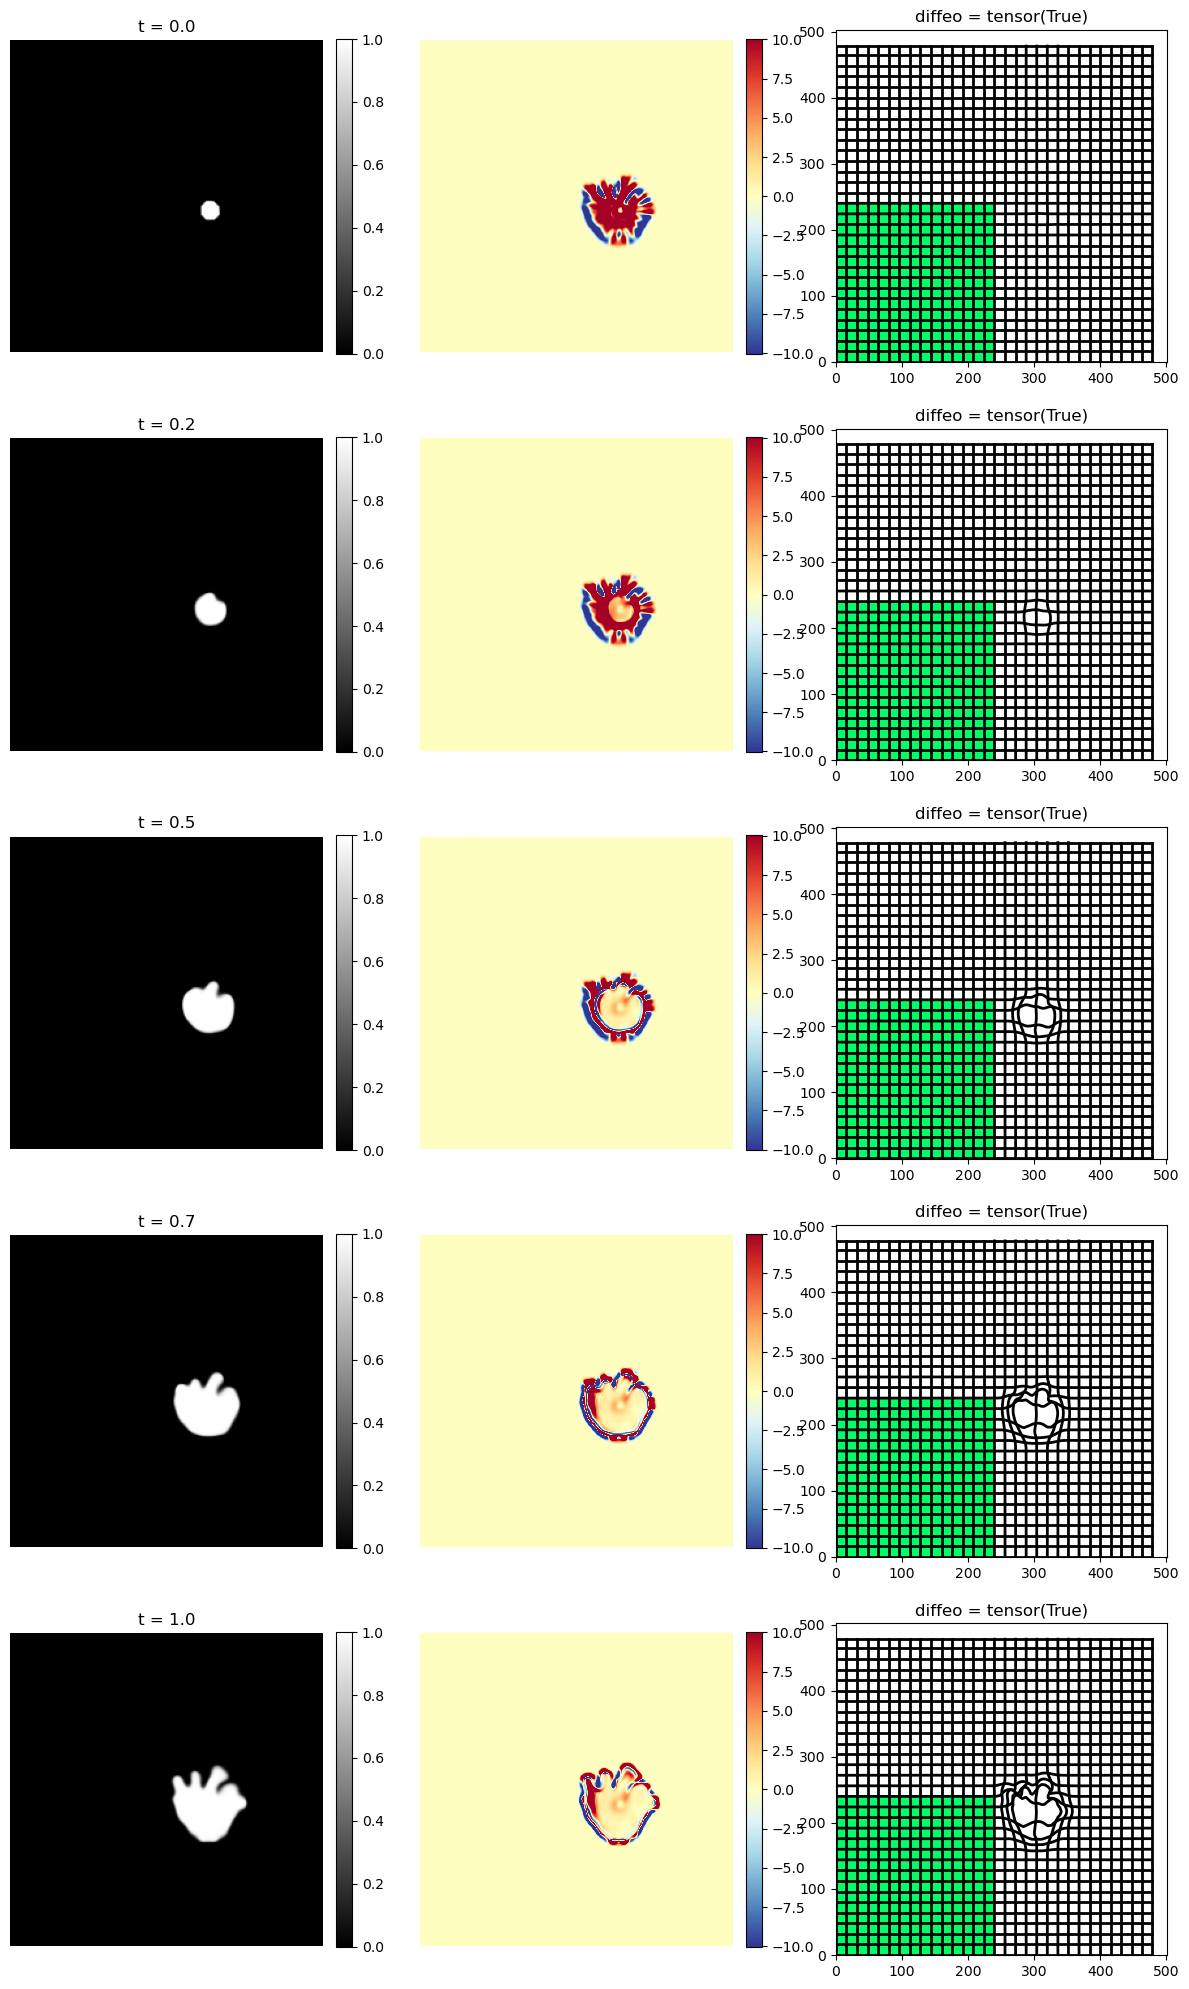

In [2]:
ini_ball,_ = tb.make_ball_at_shape_center(segmentation,overlap_threshold=0.05,verbose=True)

residuals = 0

mr = mt.lddmm(ini_ball,segmentation,residuals,3,.0001,
                    integration_steps=20,n_iter=300,grad_coef=100,
                    safe_mode=False)

mr.plot()
mr.plot_deform()
mr.mp.plot()
mask = mr.mp.image_stock

## WM computation


None
Weighted
not oriented
Progress: [##########] 100.00% Done...  ,   85.10).
 (ssd :  ,   84.47).
Computation of forward done in  0:06:14s and 0.317cents  s

Computation of weighted_metamorphosis done in  0:06:14s and 0.319cents  s

Computation done in  0:06:14s and 0.319cents  s


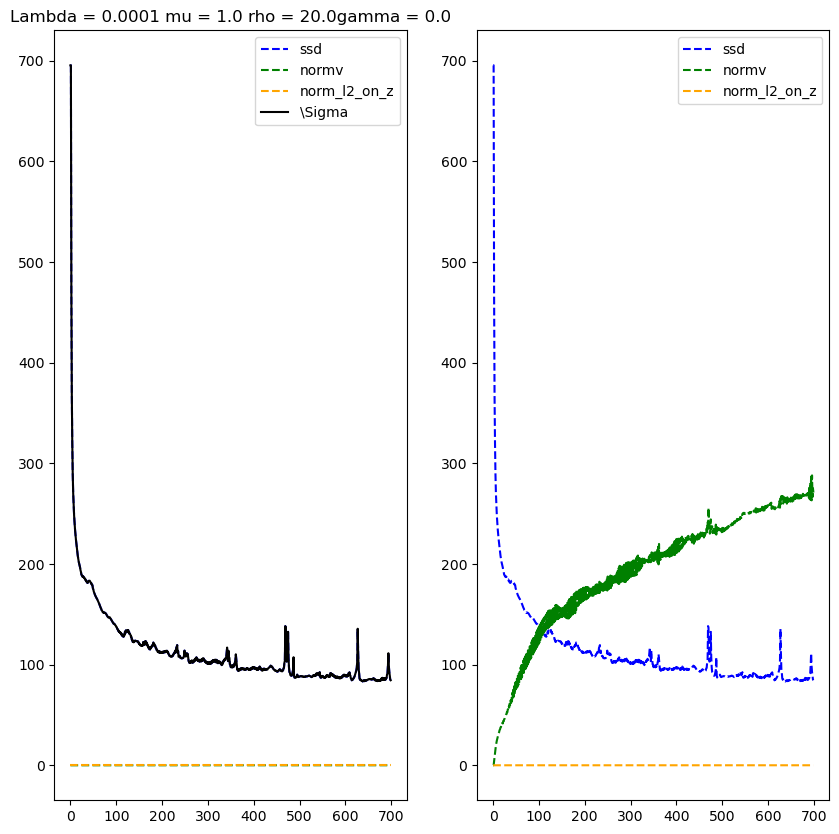

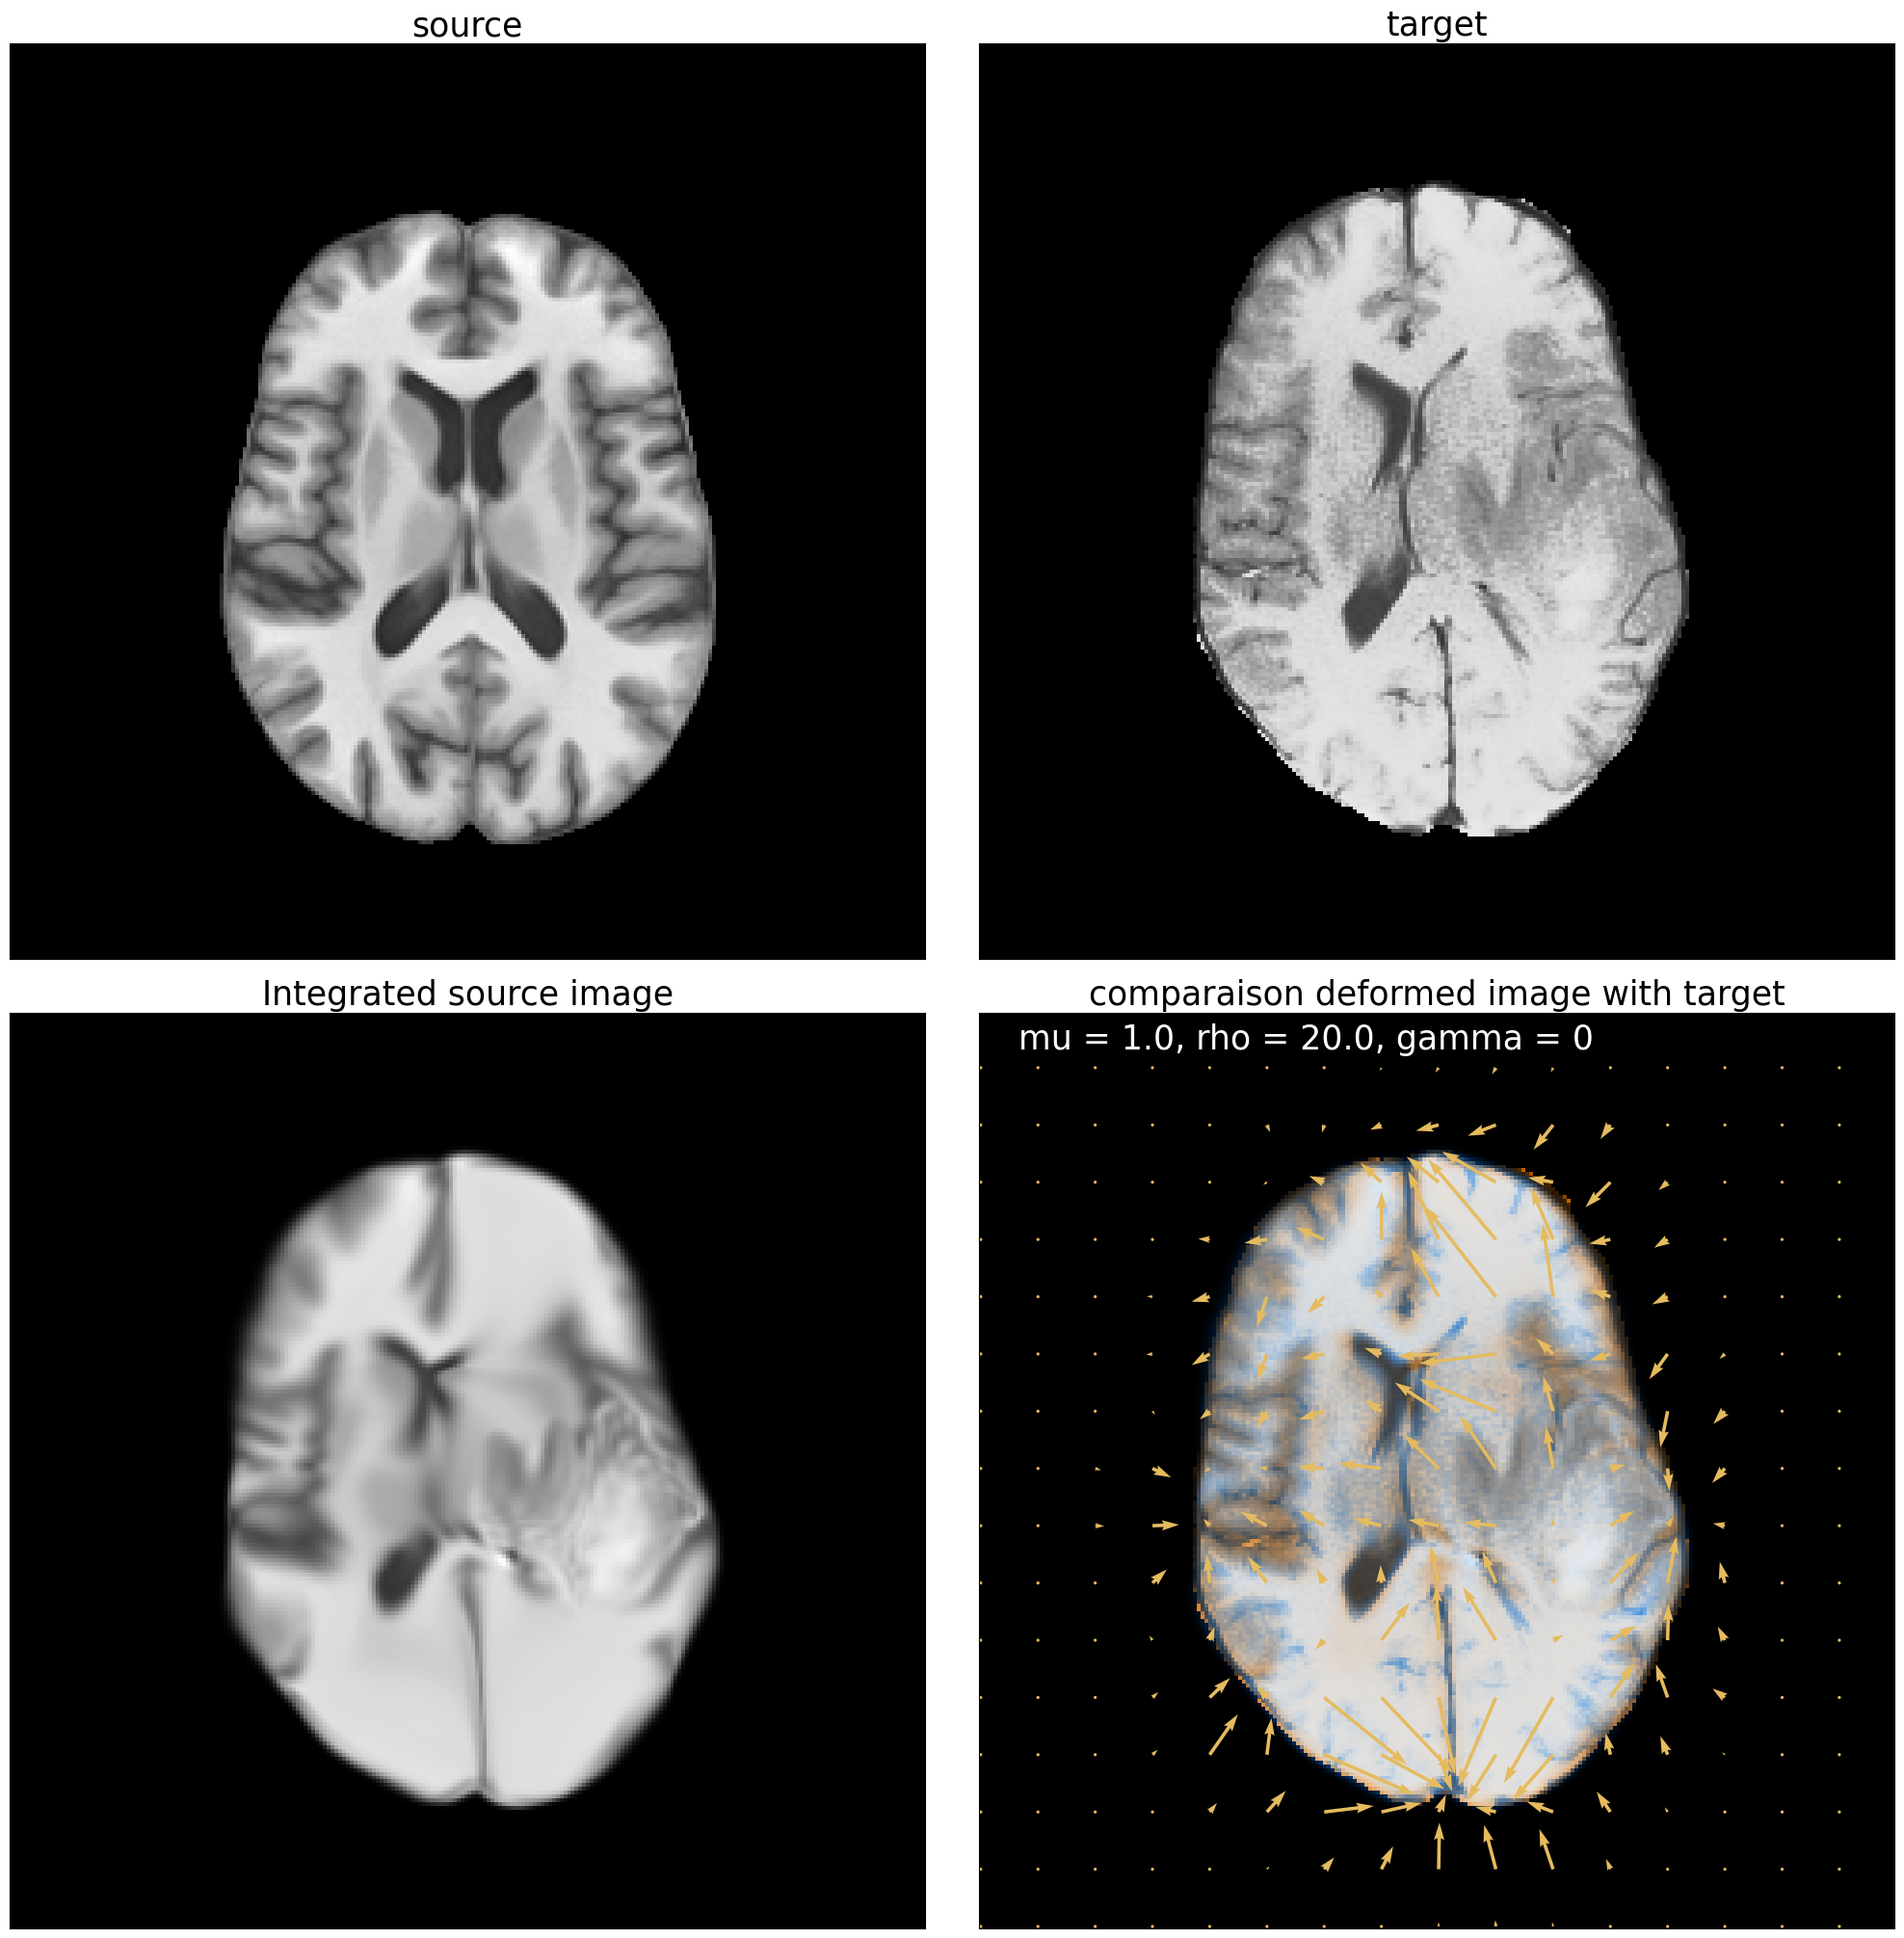

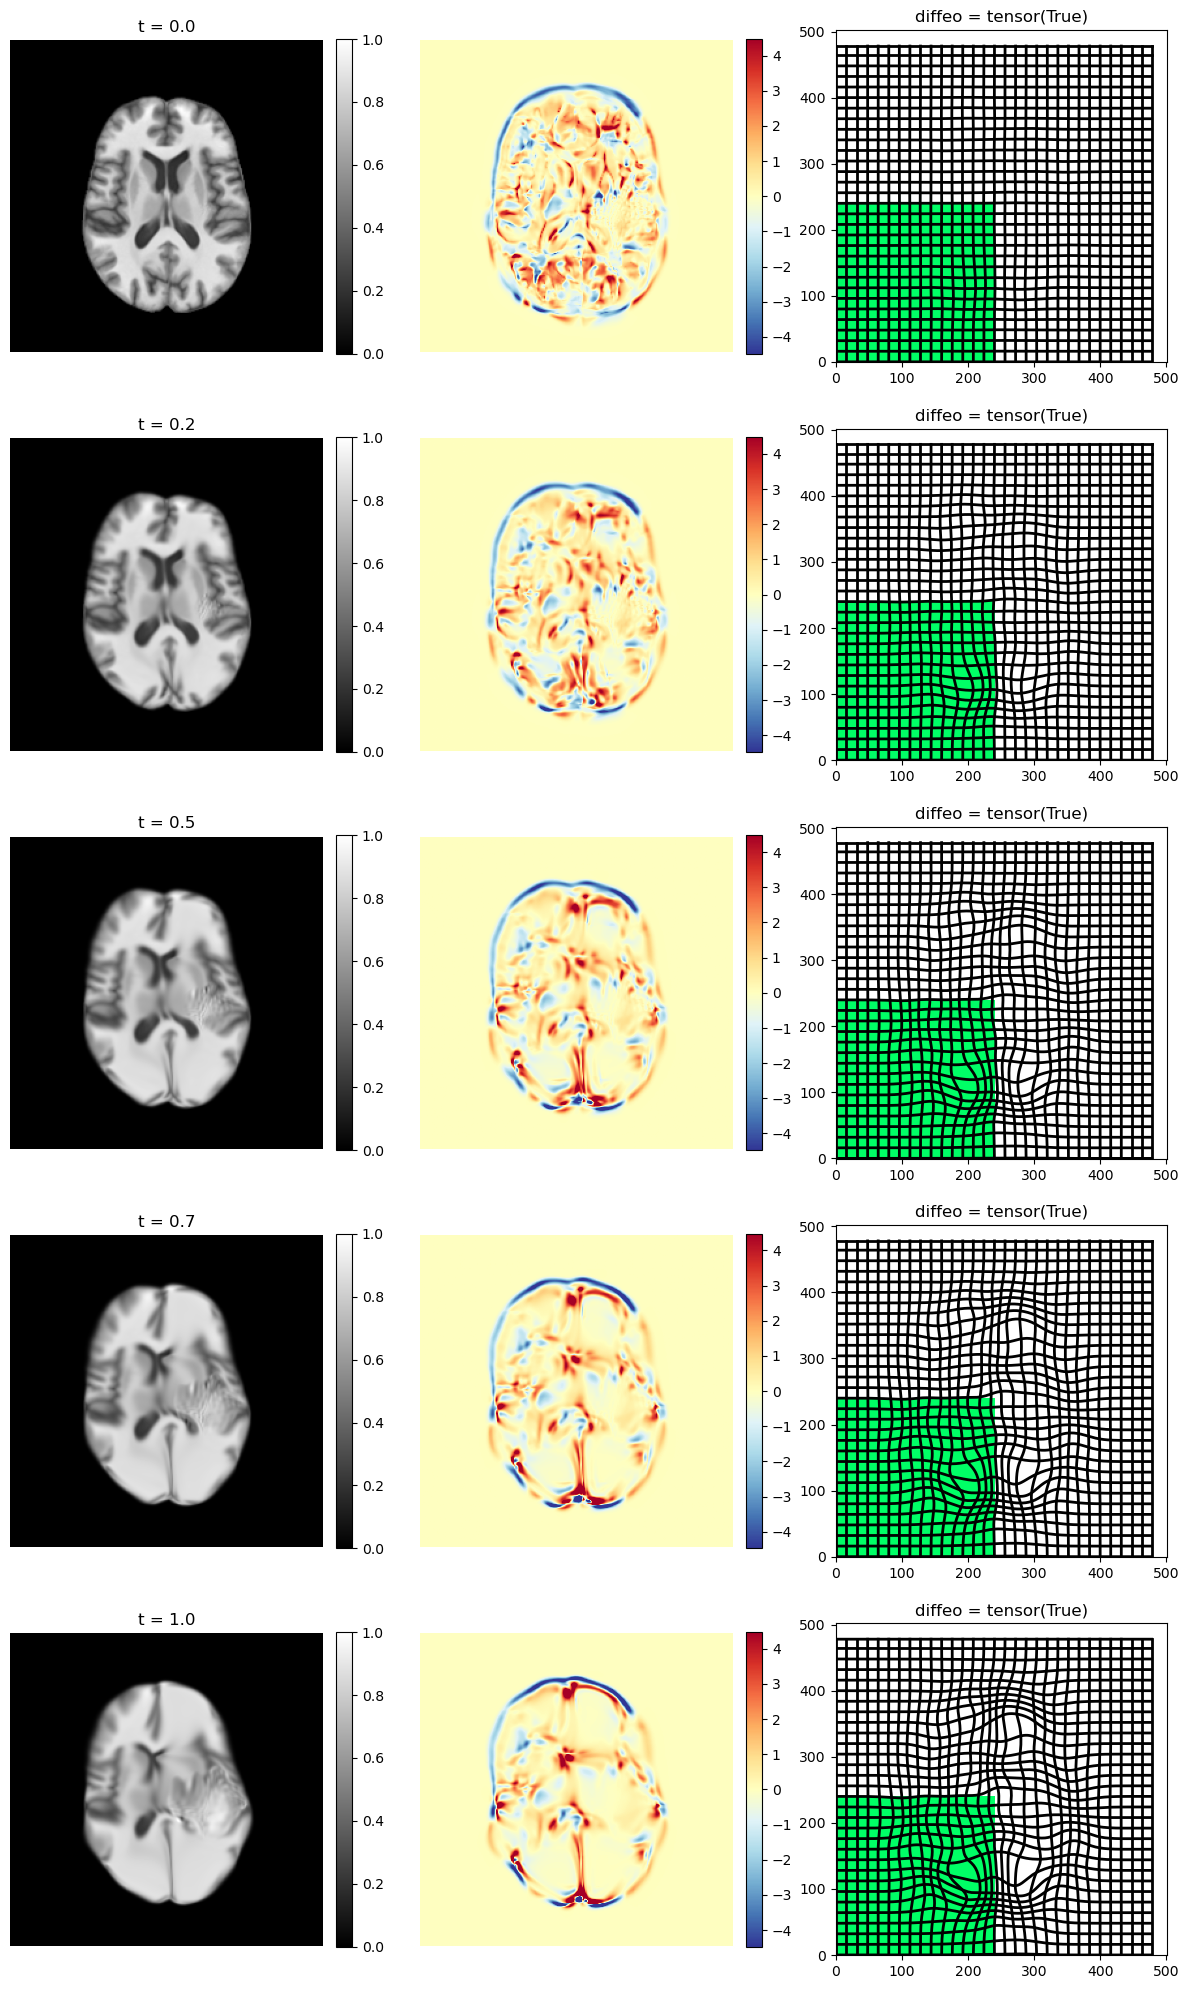

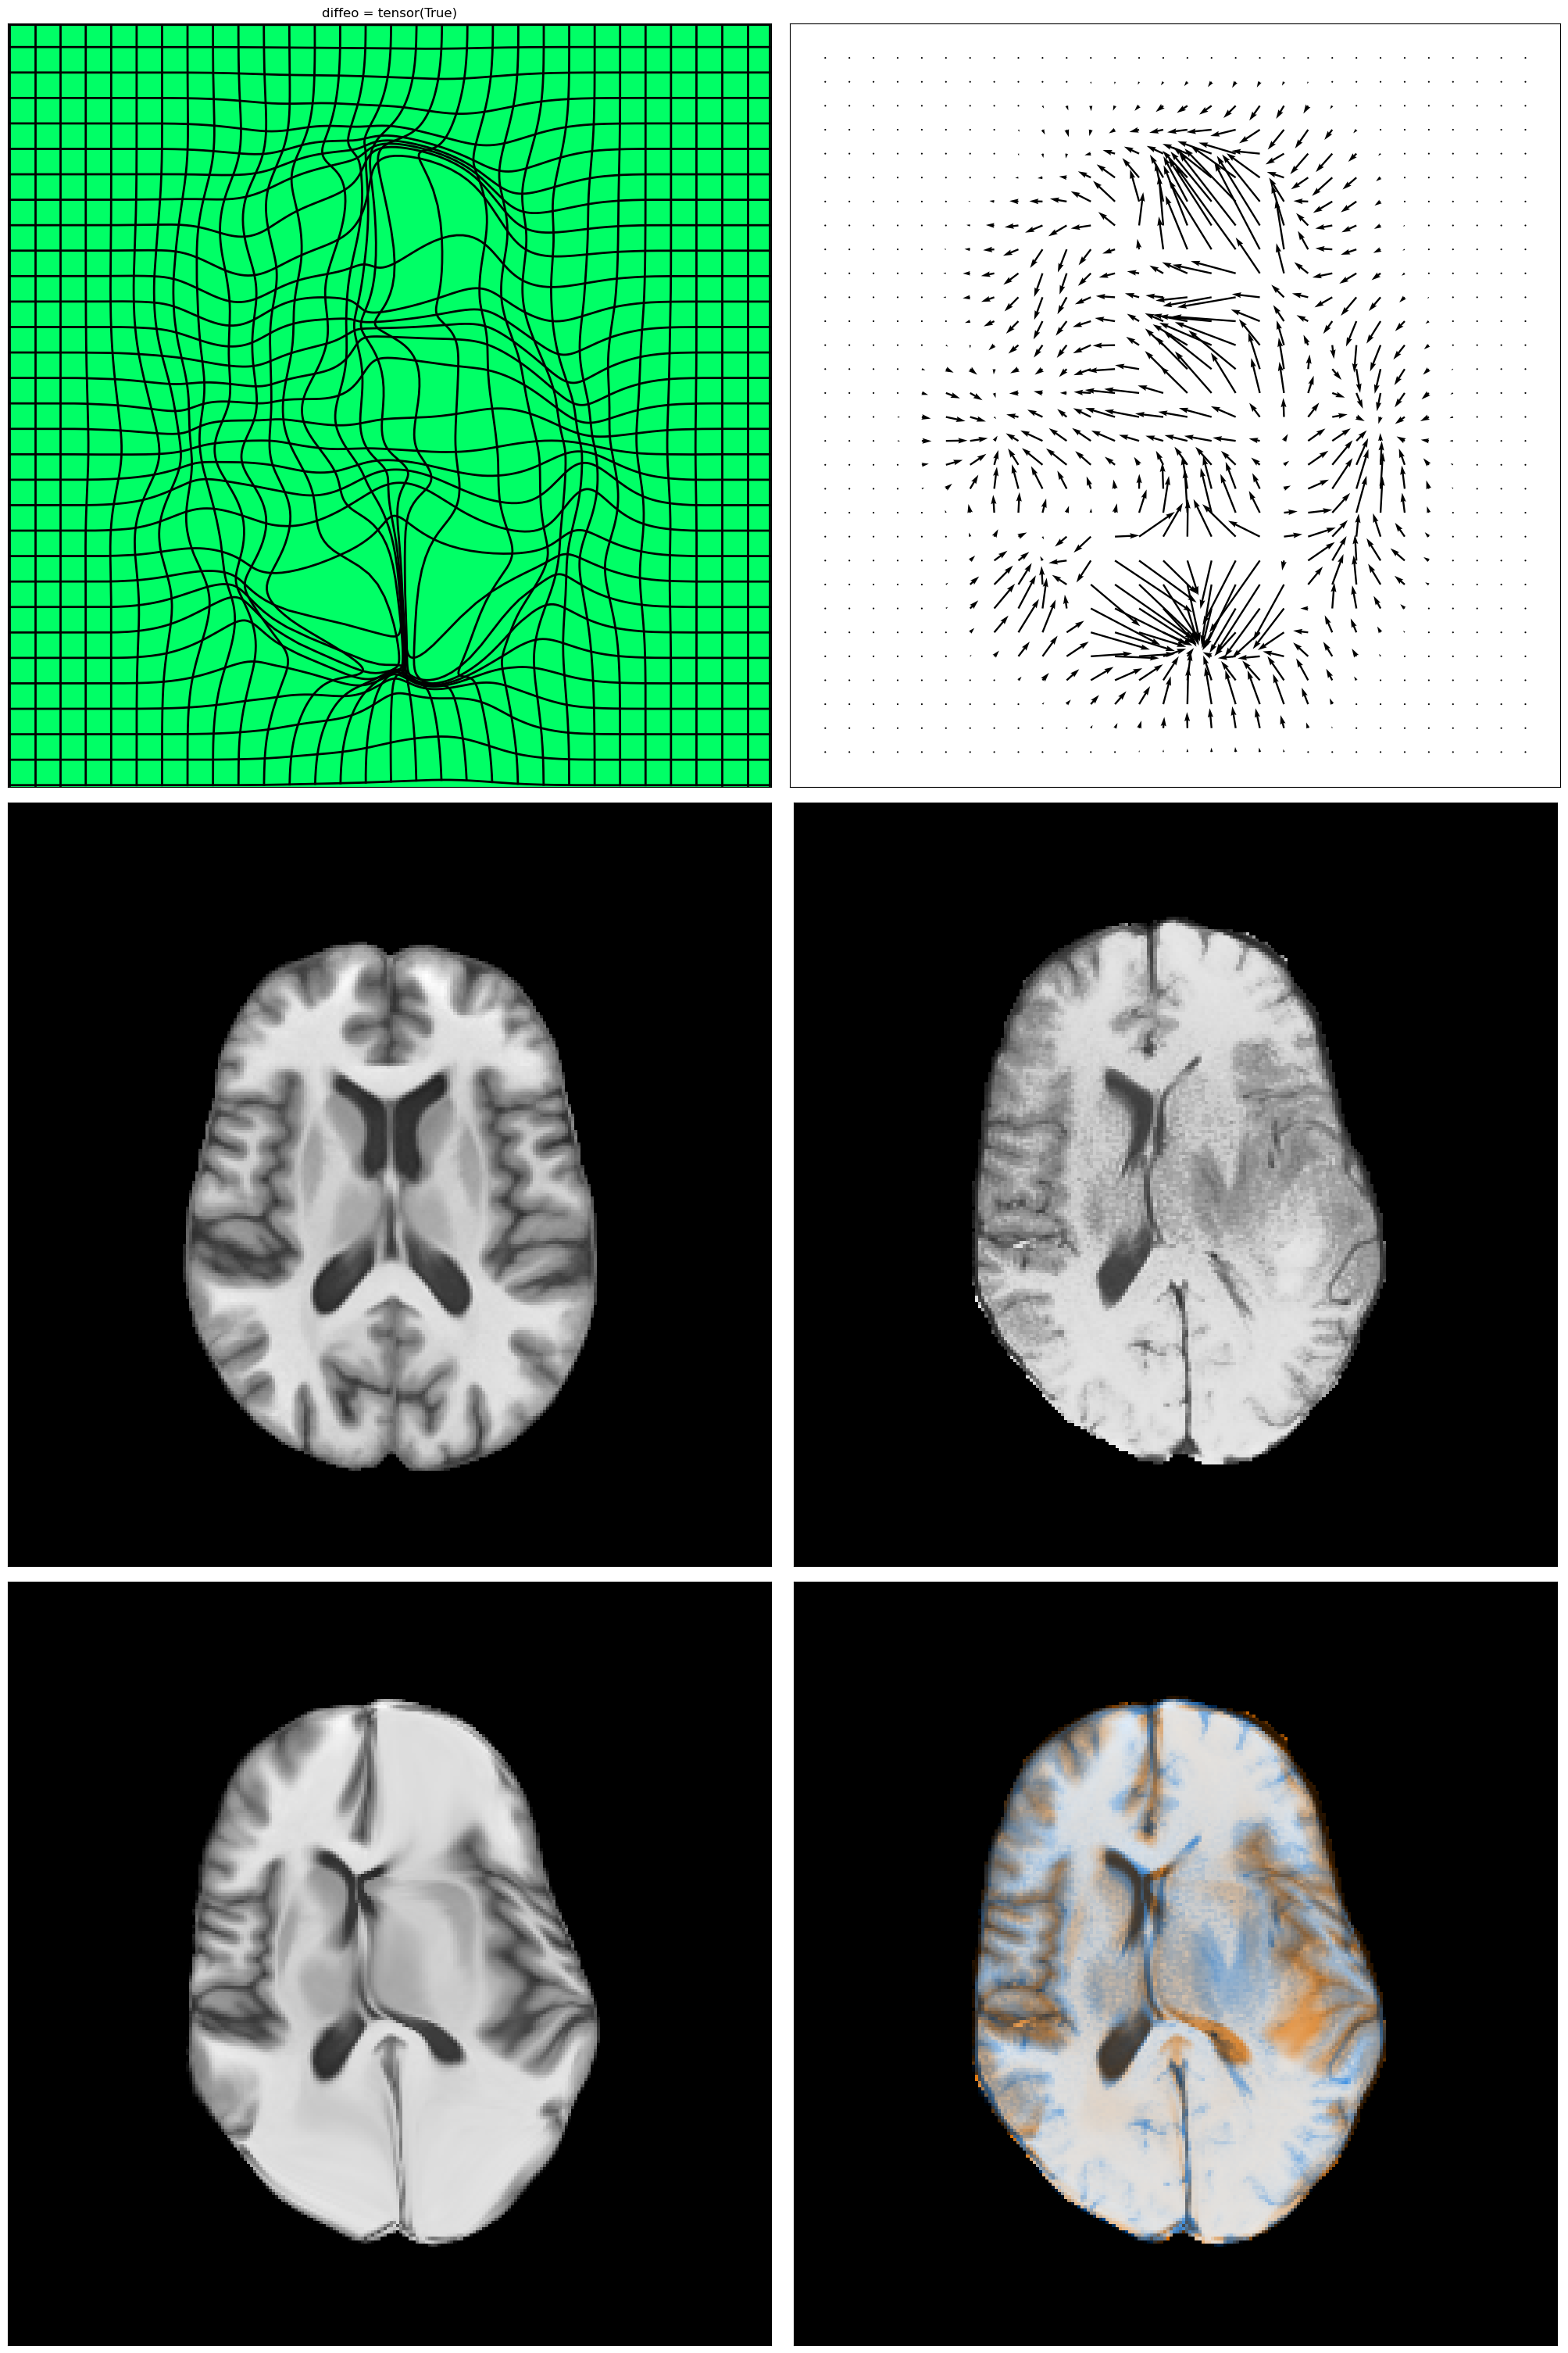

In [6]:
mu,rho,lamb,sigma = (1,20,.0001,12)
n_iter,grad_coef = (700,1)
residuals = 0
start = time.time()
mr_wm = mt.weighted_metamorphosis(source,target,residuals,mask,
                    mu,rho,'identity',sigma,lamb,
                    n_iter,grad_coef,
                    safe_mode=False)

end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_wm.plot()
mr_wm.mp.plot()
mr_wm.plot_deform()

<img src="gifs/brains_WBIR_BraTS2021_00090_WM_3.gif" width="750" align="center">